In [1]:
import re
import pandas as pd
import seaborn as sns
import copy
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from pprint import pprint
from collections import defaultdict
import json
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from matplotlib.patches import ConnectionPatch
import io


plt.rcParams.update({'font.size': 12})
plt.rcParams.update({'font.weight': 'bold'})
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42


# hatches = ['o', '*', '\\\\', 'O', 'x', '\\', '--', 'o']
hatches = ["//", "O", "\\\\"]
# markers = ['o', '*', "^", "s", "d"]
markers = ["d", "s", "^", "*"]

linestyles = ['dashdot', 'solid', '--', ":"]
orig_colors = sns.color_palette("colorblind")
colors = [
    orig_colors[2],
    orig_colors[4],
    orig_colors[0],
    orig_colors[1],
    orig_colors[3],
    orig_colors[5],
    orig_colors[7],
    orig_colors[8],
    orig_colors[9],
]
FWD_TIME_COLOR = orig_colors[0]
BWD_TIME_COLOR = orig_colors[1]
STEP_TIME_COLOR = orig_colors[2]
GPU_PER_NODE = 4
num_steps = 10
# 
MODELS = {
    20: { "m": 20, "F": 20480, "N":40, "L": 64, "U": 2048, "H": 5120, "T": 752563836},
    30: { "m": 30, "F": 0, "N":40, "L": 64, "U": 2048, "H": 5120, "T": 752563836},
    40: { "m": 40, "F": 10480, "N":128, "L": 40, "U": 2048, "H": 5120, "T": 752563836},
    52: { "m": 52, "F": 8192, "N":64, "L": 64, "U": 2048, "H": 8192, "T": 691850688},
    70: { "m": 70, "F": 8192, "N":80, "L": 64, "U": 2048, "H": 8192, "T": 1071964372 },
    # 100: { "m": 100, "F": 9216, "N": 88, "L": 72, "U": 2048, "H": 9216, "T": 1654461832 },
    100: { "m": 100, "F": 8192, "N": 124, "L": 64, "U": 2048, "H": 8192, "T": 1654461832 },
    120: { "m": 120, "F": 10240, "N":96, "L": 80, "U": 2048, "H": 10240, "T": 1667647980 },
    130: { "m": 130, "F": 12288, "N":70, "L": 96, "U": 2048, "H": 12288, "T": 1667647980 }
}

DRAM_ONLY= "DRAM Only"
DRAM_CXL = "DRAM+CXL"
DRAM_NVME = "NVMe"

approach_code = {
    0: DRAM_ONLY,
    1: DRAM_CXL,
    2: DRAM_NVME,
}
# 0: "ddr128-re-run-new-bios",
approach_ext = {
    0: "ddr128-re-run-new-bios",
    1: "ddr128-cxl256-re-run-new-bios",
    2: "ddr128-nvme5-re-run-new-bios"
}
rev_approach_code = {v: k for k, v in approach_code.items()}
base_config = {"basepath":"./", "approach": DRAM_ONLY, "dp": 4, "tp": 1, "ga": 1, "tf_ratio":1, 
                "act_ckpt":True, "mbs": 1, "gbs": 4, "ext": "ddr64"}
df_columns = [
    'elapsed_time_per_iteration_ms', 
    'TFLOPs', 
    'fwd', 
    'bwd', 
    'step',
    'bwd_inner_microstep', 
    'bwd_allreduce_microstep', 
    'step_microstep'
]

def get_filename(m, c):
    filename = (
            f"{c['basepath']}/log-{m['m']}B-tp{c['tp']}-dp{c['dp']}-"
            f"gbs{c['gbs']}-mbs{c['mbs']}-"
            f"cores56-gpus{c['gpus']}-{c['ext']}.log"
    )
    return filename

def parse_log(m, c):
    
    log_file = get_filename(m, c)
    print(f"Reading {log_file}")       
    data = {k: [] for k in df_columns}
    with open(log_file, 'r') as file:
        for line in file:
            match = re.search(r'elapsed time per iteration \(ms\): (\d+\.\d+)', line)
            if match:
                data['elapsed_time_per_iteration_ms'].append(float(match.group(1)))

            match = re.search(r'TFLOPs: (\d+\.\d+)', line)
            if match:
                data['TFLOPs'].append(float(match.group(1)))

            match = re.search(r'fwd: (\d+\.\d+)', line)
            if match:
                data['fwd'].append(float(match.group(1)))

            match = re.search(r'bwd: (\d+\.\d+)', line)
            if match:
                data['bwd'].append(float(match.group(1)))
            
            match = re.search(r'\|\s*step: (\d+\.\d+)', line)
            if match:
                data['step'].append(float(match.group(1)))

            match = re.search(r'bwd_inner_microstep: (\d+\.\d+)', line)
            if match:
                data['bwd_inner_microstep'].append(float(match.group(1)))

            match = re.search(r'bwd_allreduce_microstep: (\d+\.\d+)', line)
            if match:
                data['bwd_allreduce_microstep'].append(float(match.group(1)))

            match = re.search(r'step_microstep: (\d+\.\d+)', line)
            if match:
                data['step_microstep'].append(float(match.group(1)))
    
    if len(data['step']) == 0:  # This means that we couldn't complete even one step due to OOM
        data = {k: None for k in df_columns}
    df = pd.DataFrame(data, columns=df_columns)
    
    # We would have 10 values, select the last 5 of them
    # df = df.tail(len(df.index)-1)
    df = df.iloc[2:5]
    return df

def get_avg(arr):
    try:
        return sum(arr)/len(arr)
    except Exception as e:
        print(f"Error in get_avg {e}")


Reading ./newbios-rerun/figure-1//log-20B-tp1-dp4-gbs4-mbs1-cores56-gpus4-ddr128-re-run-new-bios.log
Reading ./newbios-rerun/figure-1//log-20B-tp1-dp4-gbs4-mbs1-cores56-gpus4-ddr128-re-run-new-bios.log
Reading ./newbios-rerun/figure-1//log-20B-tp1-dp4-gbs4-mbs1-cores56-gpus4-ddr128-nvme5-re-run-new-bios.log
Reading ./newbios-rerun/figure-1//log-30B-tp1-dp4-gbs4-mbs1-cores56-gpus4-ddr128-re-run-new-bios.log
Reading ./newbios-rerun/figure-1//log-30B-tp1-dp4-gbs4-mbs1-cores56-gpus4-ddr128-re-run-new-bios.log
Reading ./newbios-rerun/figure-1//log-30B-tp1-dp4-gbs4-mbs1-cores56-gpus4-ddr128-nvme5-re-run-new-bios.log
Reading ./newbios-rerun/figure-1//log-40B-tp1-dp4-gbs4-mbs1-cores56-gpus4-ddr128-re-run-new-bios.log
Reading ./newbios-rerun/figure-1//log-40B-tp1-dp4-gbs4-mbs1-cores56-gpus4-ddr128-cxl256-re-run-new-bios.log
Reading ./newbios-rerun/figure-1//log-40B-tp1-dp4-gbs4-mbs1-cores56-gpus4-ddr128-nvme5-re-run-new-bios.log
Reading ./newbios-rerun/figure-1//log-52B-tp1-dp4-gbs4-mbs1-cores5

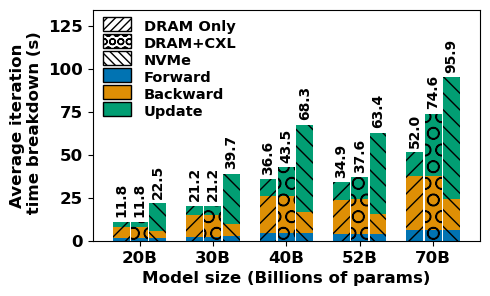

In [3]:
###############################################################
# Plot for different model sizes the breakdown of the iteration time.
###############################################################
def plot_diff_models_iter_time(config, data):
    output_file = f"./plots/diff-models-iter-time"
    
    group_labels = list(data.keys())
    bar_labels = list(data[group_labels[0]].keys())
    bar_width = 0.25
    bar_gap = -0.02
    xrange = np.arange(len(group_labels))

    fig, ax = plt.subplots(figsize=(5, 3))
#     ax2 = ax.twinx()
    start_offset = -1
    offset = start_offset
    iter_time = {}
    fwd_time = {}
    bwd_time = {}
    step_time = {}
    
    # Add the legend for hatches first
    for i, blabel in enumerate(bar_labels):
        label = approach_code[blabel]
        ax.bar(xrange, np.zeros(len(xrange)), label=label, hatch=hatches[i], color='white')
    
    # Plot the bars
    for i, blabel in enumerate(bar_labels):
        try:
            iter_time[blabel] = [get_avg(data[glabel][blabel]['elapsed_time_per_iteration_ms'])/1e3 for glabel in group_labels]
            fwd_time[blabel] = [get_avg(data[glabel][blabel]['fwd'])/1e3 for glabel in group_labels]
            bwd_time[blabel] = [get_avg(data[glabel][blabel]['bwd'])/1e3 for glabel in group_labels]
            step_time[blabel] = [get_avg(data[glabel][blabel]['step'])/1e3 for glabel in group_labels]
            # iter_time[blabel] = fwd_time[blabel] + bwd_time[blabel] + step_time[blabel]
        except Exception as e:
            print(f"Error for {blabel}")
        print("running ", blabel)
        bottom = np.zeros(len(fwd_time[blabel]))
        ax.bar(xrange + offset * bar_width, fwd_time[blabel], bar_width+bar_gap, 
               label=f'Forward', bottom=bottom, color=FWD_TIME_COLOR, hatch=hatches[i])
        bottom += fwd_time[blabel]
        ax.bar(xrange + offset * bar_width, bwd_time[blabel], bar_width+bar_gap, 
               label=f'Backward', bottom=bottom, color=BWD_TIME_COLOR, hatch=hatches[i])
        bottom += bwd_time[blabel]
        ax.bar(xrange + offset * bar_width, step_time[blabel], bar_width+bar_gap, 
               label=f'Update', bottom=bottom, color=STEP_TIME_COLOR, hatch=hatches[i])
        offset += 1
    
    # Annotate the bars
    max_y = 0
    for j, glabel in enumerate(group_labels):
        offset = start_offset
        for i, blabel in enumerate(bar_labels):
            value = iter_time[blabel][j]
            max_y = max(max_y, value)
            ax.annotate(f'{value:.1f}', (xrange[j] + offset * bar_width, value + 2), 
                        ha='center', va='bottom', rotation=90, fontsize=10, fontweight='bold', zorder=100)
            offset += 1
    
    ax.set_ylabel('Average iteration\n time breakdown (s)', fontsize=12, fontweight='bold')
    ax.set_xlabel('Model size (Billions of params)', fontsize=12, fontweight='bold')
    ax.set_xticks(xrange)
    ax.set_xticklabels([f"{x}B" for i, x in enumerate(group_labels)])
    ax.set_ylim(top=max_y*1.4)
    handles, labels = ax.get_legend_handles_labels()
    labels = labels[:len(bar_labels)+3]
    legends = ax.legend(handles, labels, 
                        ncol=1, frameon=False, fontsize=10.5, loc='upper left',
             borderpad=0.2, labelspacing=0.2, columnspacing=0.5, ) 
    for i, handle in enumerate(legends.legend_handles):
        handle.set_edgecolor('black')
        handle.set_height(10)
        handle.set_width(20)
        if i < len(bar_labels):
            handle.set_hatch(handle.get_hatch()*2)
        else:
            handle.set_hatch(None)

    
    plt.savefig(f"{output_file}.eps", format='eps', bbox_inches='tight')
    plt.savefig(f"{output_file}.png", format='png', bbox_inches='tight')
    plt.show()


res = {}
for model in [20, 30, 40, 52, 70]:
    config = copy.deepcopy(base_config)
    res[model] = {}
    for k in [0, 1, 2]:
        res[model][k] = None
        config['basepath'] = f"./newbios-rerun/figure-1/"
        config['dp'] = 4
        config['mbs'] = 1
        config['tp'] = 1
        config['gpus'] = 4
        config['gbs'] = config['mbs']*config['dp']
        config['approach'] = approach_code[k]
        config['ext'] = approach_ext[k]
        if model <= 30 and k == 1: # if it is DRAM + CXL, just match it with the DRAM only.
            config['ext'] = approach_ext[0]
        ans = parse_log(MODELS[model], config)
        res[model][k] = ans

plot_diff_models_iter_time(config, res)

Reading ./newbios-rerun/figure-1//log-20B-tp1-dp4-gbs4-mbs1-cores56-gpus4-ddr128-re-run-new-bios.log
Reading ./newbios-rerun/figure-1//log-20B-tp1-dp4-gbs4-mbs1-cores56-gpus4-ddr128-re-run-new-bios.log
Reading ./newbios-rerun/figure-1//log-20B-tp1-dp4-gbs4-mbs1-cores56-gpus4-ddr128-nvme5-re-run-new-bios.log
Reading ./newbios-rerun/figure-1//log-30B-tp1-dp4-gbs4-mbs1-cores56-gpus4-ddr128-re-run-new-bios.log
Reading ./newbios-rerun/figure-1//log-30B-tp1-dp4-gbs4-mbs1-cores56-gpus4-ddr128-re-run-new-bios.log
Reading ./newbios-rerun/figure-1//log-30B-tp1-dp4-gbs4-mbs1-cores56-gpus4-ddr128-nvme5-re-run-new-bios.log
Reading ./newbios-rerun/figure-1//log-40B-tp1-dp4-gbs4-mbs1-cores56-gpus4-ddr128-re-run-new-bios.log
Reading ./newbios-rerun/figure-1//log-40B-tp1-dp4-gbs4-mbs1-cores56-gpus4-ddr128-cxl256-re-run-new-bios.log
Reading ./newbios-rerun/figure-1//log-40B-tp1-dp4-gbs4-mbs1-cores56-gpus4-ddr128-nvme5-re-run-new-bios.log
Reading ./newbios-rerun/figure-1//log-52B-tp1-dp4-gbs4-mbs1-cores5

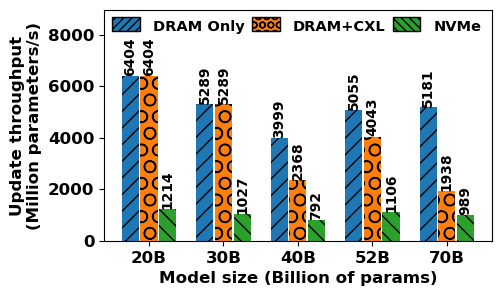

In [4]:
###############################################################
# Plot for different model sizes the update throughputs.
###############################################################
def plot_diff_models_update_thru(config, data):
    output_file = f"./plots/diff-models-update-thru"
    
    group_labels = list(data.keys())
    bar_labels = list(data[group_labels[0]].keys())
    bar_width = 0.25
    bar_gap = -0.02
    xrange = np.arange(len(group_labels))

    fig, ax = plt.subplots(figsize=(5, 3))
#     ax2 = ax.twinx()
    start_offset = -1
    offset = start_offset
    iter_time = {}
    fwd_time = {}
    bwd_time = {}
    step_time = {}
        
    # Plot the bars
    for i, blabel in enumerate(bar_labels):
        try:
            # iter_time[blabel] = [get_avg(data[glabel][blabel]['iter_time']) for glabel in group_labels]
            iter_time[blabel] = [glabel/(get_avg(data[glabel][blabel]['step'])/1e6) for glabel in group_labels]
            step_time[blabel] = [glabel/(get_avg(data[glabel][blabel]['step'])/1e6) for glabel in group_labels]
        except Exception as e:
            print(f"Error for {blabel}")
        label = approach_code[blabel]
        ax.bar(xrange + offset * bar_width, step_time[blabel], bar_width+bar_gap, hatch=hatches[i], label=label)
        offset += 1
    
    # Annotate the bars
    max_y = 0
    for j, glabel in enumerate(group_labels):
        offset = start_offset
        for i, blabel in enumerate(bar_labels):
            value = iter_time[blabel][j]
            max_y = max(max_y, value)
            ax.annotate(f'{value:.0f}', (xrange[j] + offset * bar_width, value + 15), 
                        ha='center', va='bottom', rotation=90, fontsize=10, fontweight='bold', zorder=100)
            offset += 1
    
    ax.set_ylabel('Update throughput\n(Million parameters/s)', fontsize=12, fontweight='bold')
    ax.set_xlabel('Model size (Billion of params)', fontsize=12, fontweight='bold')
    ax.set_xticks(xrange)
    ax.set_xticklabels([f"{x}B" for i, x in enumerate(group_labels)])
    ax.set_ylim(top=max_y*1.4)

    handles, labels = ax.get_legend_handles_labels()
    # labels = labels[:len(bar_labels)+3]
    legends = ax.legend(handles, labels, 
                        ncol=3, frameon=False, fontsize=10.5, loc='upper right',
             borderpad=0.2, labelspacing=0.2, columnspacing=0.5, ) 
    for i, handle in enumerate(legends.get_patches()):
        handle.set_edgecolor('black')
        handle.set_height(10)
        handle.set_width(20)
        if i < len(bar_labels):
            handle.set_hatch(handle.get_hatch()*2)
        else:
            handle.set_hatch(None)

    
    plt.savefig(f"{output_file}.eps", format='eps', bbox_inches='tight')
    plt.savefig(f"{output_file}.png", format='png', bbox_inches='tight')
    plt.show()


res = {}
for model in [20, 30, 40, 52, 70]:
    config = copy.deepcopy(base_config)
    res[model] = {}
    for k in [0, 1, 2]:
        res[model][k] = None
        config['basepath'] = f"./newbios-rerun/figure-1/"
        config['dp'] = 4
        config['mbs'] = 1
        config['tp'] = 1
        config['gpus'] = 4
        config['gbs'] = config['mbs']*config['dp']
        config['approach'] = approach_code[k]
        config['ext'] = approach_ext[k]
        if model <= 30 and k == 1: # if it is DRAM + CXL, just match it with the DRAM only.
            config['ext'] = approach_ext[0]
        ans = parse_log(MODELS[model], config)
        res[model][k] = ans

plot_diff_models_update_thru(config, res)

Reading ./figure-3//log-70B-tp1-dp4-gbs4-mbs1-cores56-gpus4-ddr128-re-run-new-bios.log
Reading ./figure-3//log-70B-tp1-dp4-gbs4-mbs1-cores56-gpus4-ddr-cxl.log
Reading ./figure-3//log-70B-tp1-dp4-gbs4-mbs1-cores56-gpus4-ddr-nvme.log
Reading ./figure-3//log-70B-tp1-dp4-gbs16-mbs1-cores56-gpus4-ddr128-re-run-new-bios.log
Reading ./figure-3//log-70B-tp1-dp4-gbs16-mbs1-cores56-gpus4-ddr-cxl.log
Reading ./figure-3//log-70B-tp1-dp4-gbs16-mbs1-cores56-gpus4-ddr-nvme.log
Reading ./figure-3//log-70B-tp1-dp4-gbs32-mbs1-cores56-gpus4-ddr128-re-run-new-bios.log
Reading ./figure-3//log-70B-tp1-dp4-gbs32-mbs1-cores56-gpus4-ddr-cxl.log
Reading ./figure-3//log-70B-tp1-dp4-gbs32-mbs1-cores56-gpus4-ddr-nvme.log
Reading ./figure-3//log-70B-tp1-dp4-gbs64-mbs1-cores56-gpus4-ddr128-re-run-new-bios.log
Reading ./figure-3//log-70B-tp1-dp4-gbs64-mbs1-cores56-gpus4-ddr-cxl.log
Reading ./figure-3//log-70B-tp1-dp4-gbs64-mbs1-cores56-gpus4-ddr-nvme.log
Reading ./figure-3//log-70B-tp1-dp4-gbs128-mbs1-cores56-gpus4-d

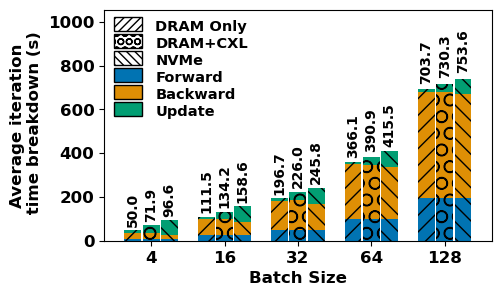

In [78]:
###############################################################
# Plot for different gradient accumulation degrees.
###############################################################
def plot_diff_grad_accum_iter_time(config, data):
    output_file = f"./plots/diff-grad-accum-iter-time"
    
    group_labels = list(data.keys())
    bar_labels = list(data[group_labels[0]].keys())
    bar_width = 0.25
    bar_gap = -0.02
    xrange = np.arange(len(group_labels))

    fig, ax = plt.subplots(figsize=(5, 3))
#     ax2 = ax.twinx()
    start_offset = -1
    offset = start_offset
    iter_time = {}
    fwd_time = {}
    bwd_time = {}
    step_time = {}
    
    # Add the legend for hatches first
    for i, blabel in enumerate(bar_labels):
        label = approach_code[blabel]
        ax.bar(xrange, np.zeros(len(xrange)), label=label, hatch=hatches[i], color='white')
    
    # Plot the bars
    for i, blabel in enumerate(bar_labels):
        try:
            iter_time[blabel] = [get_avg(data[glabel][blabel]['elapsed_time_per_iteration_ms']/1e3) for glabel in group_labels]
            fwd_time[blabel] = [get_avg(data[glabel][blabel]['fwd'])/1e3 for glabel in group_labels]
            bwd_time[blabel] = [get_avg(data[glabel][blabel]['bwd'])/1e3 for glabel in group_labels]
            step_time[blabel] = [get_avg(data[glabel][blabel]['step'])/1e3 for glabel in group_labels]
        
            bottom = np.zeros(len(fwd_time[blabel]))
            ax.bar(xrange + offset * bar_width, fwd_time[blabel], bar_width+bar_gap, 
                   label=f'Forward', bottom=bottom, color=FWD_TIME_COLOR, hatch=hatches[i])
            bottom += fwd_time[blabel]
            ax.bar(xrange + offset * bar_width, bwd_time[blabel], bar_width+bar_gap, 
                   label=f'Backward', bottom=bottom, color=BWD_TIME_COLOR, hatch=hatches[i])
            bottom += bwd_time[blabel]
            ax.bar(xrange + offset * bar_width, step_time[blabel], bar_width+bar_gap, 
                   label=f'Update', bottom=bottom, color=STEP_TIME_COLOR, hatch=hatches[i])
            offset += 1
        except Exception as e:
            print(f"Error for bars: {blabel}: {bar_labels}, {e}")
    
    # Annotate the bars
    max_y = 0
    for j, glabel in enumerate(group_labels):
        try:
            offset = start_offset
            for i, blabel in enumerate(bar_labels):
                value = iter_time[blabel][j]
                max_y = max(max_y, value)
                ax.annotate(f'{value:.1f}', (xrange[j] + offset * bar_width, value + 15), 
                            ha='center', va='bottom', rotation=90, fontsize=10, fontweight='bold', zorder=100)
                offset += 1
        except Exception as e:
            print(f"Error for {glabel}: {group_labels}, {e}")
    
    ax.set_ylabel('Average iteration\n time breakdown (s)', fontsize=12, fontweight='bold')
    ax.set_xlabel('Batch Size', fontsize=12, fontweight='bold')
    ax.set_xticks(xrange)
    ax.set_xticklabels([f"{x*config['dp']*config['mbs']}" for i, x in enumerate(group_labels)])
    ax.set_ylim(top=max_y*1.4)
    # Plot the TFLOPs on secondary y-axis
#     tflops = {}
#     for i, blabel in enumerate(bar_labels):
#         tflops[blabel] = [get_avg(data[glabel][blabel]['TFLOPs']) for glabel in group_labels]
#         ax2.plot(xrange, tflops[blabel], color='blue', marker=markers[i], linestyle=linestyles[i],
#                  markersize=10, markerfacecolor=colors[i], markeredgecolor=colors[i], zorder=1)
#     ax2.tick_params(axis='y', color='blue', labelcolor='blue')
#     ax2.spines['right'].set_color('blue')
#     ax2.set_ylabel('TFLOPs (lines)', fontsize=12, fontweight='bold', color='blue')    
#     ax2.set_ylim(bottom=-20)

    handles, labels = ax.get_legend_handles_labels()
    labels = labels[:len(bar_labels)+3]
    legends = ax.legend(handles, labels, 
                        ncol=1, frameon=False, fontsize=10.5, loc='upper left',
             borderpad=0.2, labelspacing=0.2, columnspacing=0.5, ) 
    for i, handle in enumerate(legends.legend_handles):
        handle.set_edgecolor('black')
        handle.set_height(10)
        handle.set_width(20)
        if i < len(bar_labels):
            handle.set_hatch(handle.get_hatch()*2)
        else:
            handle.set_hatch(None)

    
    plt.savefig(f"{output_file}.eps", format='eps', bbox_inches='tight')
    plt.savefig(f"{output_file}.png", format='png', bbox_inches='tight')
    plt.show()


res = {}
model = 70
for ga in [1, 4, 8, 16, 32]:
    config = copy.deepcopy(base_config)
    res[ga] = {}
    for k in [0, 1, 2]:
        res[ga][k] = None
        config['basepath'] = f"./figure-3/"
        config['dp'] = 4
        config['mbs'] = 1
        config['tp'] = 1
        config['gpus'] = 4
        config['gbs'] = config['mbs']*config['dp']*ga
        config['approach'] = approach_code[k]
        config['ext'] = approach_ext[k]
        if model <= 30 and k == 1: # if it is DRAM + CXL, just match it with the DRAM only.
            config['ext'] = approach_ext[0]
        ans = parse_log(MODELS[model], config)
        res[ga][k] = ans

plot_diff_grad_accum_iter_time(config, res)

FILENAME, START_TIMESTAMP_DS, END_TIMESTAMP_DS, MEAN_CPU_UTIL_%
./newbios-rerun/figure-4//avi-log-20B-tp1-dp4-gbs4-mbs1-cores56-gpus4-ddr128-re-run-new-bios.csv 2025-02-15 16:49:30.404 2025-02-15 16:49:33.728 55.2
./newbios-rerun/figure-4//avi-log-20B-tp1-dp4-gbs4-mbs1-cores56-gpus4-ddr128-re-run-new-bios.csv 2025-02-15 16:49:30.404 2025-02-15 16:49:33.728 55.2
./newbios-rerun/figure-4//avi-log-20B-tp1-dp4-gbs4-mbs1-cores56-gpus4-ddr128-nvme5-re-run-new-bios.csv 2025-02-15 17:46:14.939 2025-02-15 17:46:31.399 11.049999999999999
./newbios-rerun/figure-4//avi-log-30B-tp1-dp4-gbs4-mbs1-cores56-gpus4-ddr128-re-run-new-bios.csv 2025-02-15 17:09:46.780 2025-02-15 17:09:52.677 52.366666666666674
./newbios-rerun/figure-4//avi-log-30B-tp1-dp4-gbs4-mbs1-cores56-gpus4-ddr128-re-run-new-bios.csv 2025-02-15 17:09:46.780 2025-02-15 17:09:52.677 52.366666666666674
./newbios-rerun/figure-4//avi-log-30B-tp1-dp4-gbs4-mbs1-cores56-gpus4-ddr128-nvme5-re-run-new-bios.csv 2025-02-15 17:56:24.496 2025-02-15 

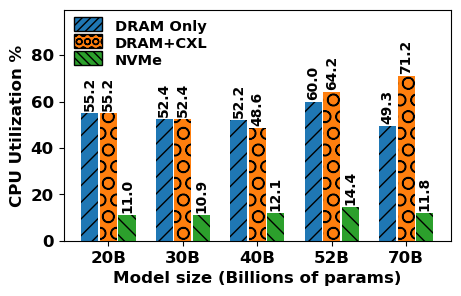

In [32]:
###############################################################
# Plot for different CPU utilization values
###############################################################
def plot_diff_cpu_util(config, data):
    output_file = f"./plots/diff-cpu-util-time"
    
    group_labels = list(data.keys())
    bar_labels = list(data[group_labels[0]].keys())
    bar_width = 0.25
    bar_gap = -0.02
    xrange = np.arange(len(group_labels))

    fig, ax = plt.subplots(figsize=(5, 3))
#     ax2 = ax.twinx()
    start_offset = -1
    offset = start_offset
    
    # Add the legend for hatches first
    # for i, blabel in enumerate(bar_labels):
    #     label = approach_code[blabel]
    #     ax.bar(xrange, np.zeros(len(xrange)), label=label, hatch=hatches[i], color='white')
    cpu_util = {}
    # Plot the bars
    for i, blabel in enumerate(bar_labels):
        try:
            cpu_util[blabel] = [data[glabel][blabel] for glabel in group_labels]
            ax.bar(xrange + offset * bar_width, cpu_util[blabel], bar_width+bar_gap, 
                   label=approach_code[blabel], hatch=hatches[i])
            
            offset += 1
        except Exception as e:
            print(f"Error for bars: {blabel}: {bar_labels}, {e}")
    
    # Annotate the bars
    max_y = 0
    for j, glabel in enumerate(group_labels):
        try:
            offset = start_offset
            for i, blabel in enumerate(bar_labels):
                value = cpu_util[blabel][j]
                max_y = max(max_y, value)
                ax.annotate(f'{value:.1f}', (xrange[j] + offset * bar_width, value + 1), 
                            ha='center', va='bottom', rotation=90, fontsize=10, fontweight='bold', zorder=100)
                offset += 1
        except Exception as e:
            print(f"Error for {glabel}: {group_labels}, {e}")
    
    ax.set_ylabel('CPU Utilization %', fontsize=12, fontweight='bold')
    ax.set_xlabel('Model size (Billions of params)', fontsize=12, fontweight='bold')
    ax.set_xticks(xrange)
    ax.set_xticklabels([f"{x}B" for i, x in enumerate(group_labels)])
    ax.set_ylim(top=max_y*1.4)
    handles, labels = ax.get_legend_handles_labels()
    # labels = labels[:len(bar_labels)+1]
    legends = ax.legend(handles, labels, 
                        ncol=1, frameon=False, fontsize=10.5, loc='upper left',
             borderpad=0.2, labelspacing=0.2, columnspacing=0.5, ) 
    for i, handle in enumerate(legends.legend_handles):
        handle.set_edgecolor('black')
        handle.set_height(10)
        handle.set_width(20)
        if i < len(bar_labels):
            handle.set_hatch(handle.get_hatch()*2)
        else:
            handle.set_hatch(None)

    
    plt.savefig(f"{output_file}.eps", format='eps', bbox_inches='tight')
    plt.savefig(f"{output_file}.png", format='png', bbox_inches='tight')
    plt.show()

import re
import datetime

def extract_timestamps(filepath):
    pattern = re.compile(r"<ENG_FORWARD_START, (\d{4}-\d{2}-\d{2} \d{2}:\d{2}:\d{2}\.\d{3})>")
    timestamps = []

    with open(filepath, "r") as file:
        for line in file:
            match = pattern.search(line)
            if match:
                timestamps.append(match.group(1))

            if len(timestamps) >= 13:  # Stop early if we have enough occurrences
                break

    if len(timestamps) < 13:
        raise ValueError("Not enough occurrences of 'ENG_FORWARD_START' in the log file.")
    # return to_unix_ns(timestamps[8]), to_unix_ns(timestamps[12])

    return timestamps[8], timestamps[12]

def extract_ninth_timestamps(filepath):
    step_start_pattern = r"<STEP_START, (\d{4}-\d{2}-\d{2} \d{2}:\d{2}:\d{2}\.\d+)>"
    step_end_pattern = r"<STEP_END, (\d{4}-\d{2}-\d{2} \d{2}:\d{2}:\d{2}\.\d+)>"
    
    step_start_timestamps = []
    step_end_timestamps = []

    with open(filepath, 'r') as file:
        for line in file:
            start_match = re.search(step_start_pattern, line)
            if start_match:
                step_start_timestamps.append(start_match.group(1))
            
            end_match = re.search(step_end_pattern, line)
            if end_match:
                step_end_timestamps.append(end_match.group(1))

    if len(step_start_timestamps) < 9 or len(step_end_timestamps) < 9:
        raise ValueError("Log file does not contain at least 9 occurrences of STEP_START or STEP_END.")

    return step_start_timestamps[8], step_end_timestamps[8]
    # def to_unix_timestamp(timestamp_str):
    #     dt = datetime.datetime.strptime(timestamp_str, "%Y-%m-%d %H:%M:%S.%f")
    #     return dt.timestamp()

    # step_start_unix = to_unix_timestamp(step_start_timestamps[8])
    # step_end_unix = to_unix_timestamp(step_end_timestamps[8])

    # return step_start_unix, step_end_unix

def mean_cpu_utilization(csv_filepath, st, en):
    """Calculates the mean CPU utilization between two timestamps in a CSV file."""
    try:
        df = pd.read_csv(csv_filepath)
        df["timestamp"] = pd.to_datetime(df["timestamp"], errors="coerce")  # Handle invalid timestamps
        df.dropna(subset=["timestamp"], inplace=True)  # Remove rows with NaT timestamps
        filtered_df = df[(df["timestamp"] >= pd.to_datetime(st)) & (df["timestamp"] <= pd.to_datetime(en))]
        if filtered_df.empty:
            print(f"Warning: No data found in range {st} - {en} for {csv_filepath}")
            return None  # Return None if no data is available in the range
        # print(filtered_df)
        # val = filtered_df["cpu_utilization"].sum()/((pd.to_datetime(en) - pd.to_datetime(st)).total_seconds())
        # return val
        # print(filtered_df["cpu_utilization"].sum(), )
        return filtered_df["cpu_utilization"].mean()

    except FileNotFoundError:
        print(f"CSV file not found: {csv_filepath}")
        return None


res = {}
print("FILENAME, START_TIMESTAMP_DS, END_TIMESTAMP_DS, MEAN_CPU_UTIL_%")
for model in [20, 30, 40, 52, 70]:
# for model in [70]:
    config = copy.deepcopy(base_config)
    res[model] = {}
    for k in [0, 1, 2]:
        res[model][k] = None
        config['basepath'] = f"./newbios-rerun/figure-1/"
        config['dp'] = 4
        config['mbs'] = 1
        config['tp'] = 1
        config['gpus'] = 4
        config['gbs'] = config['mbs']*config['dp']
        config['approach'] = approach_code[k]
        config['ext'] = approach_ext[k]
        if model <= 30 and k == 1: # if it is DRAM + CXL, just match it with the DRAM only.
            config['ext'] = approach_ext[0]
        filename = get_filename(MODELS[model], config)
        st, en = extract_ninth_timestamps(filename)
        # print(filename, st, en)
        filename = filename.replace(".log", ".csv")
        filename = filename.replace("log-", "avi-log-")
        filename = filename.replace("figure-1", "figure-4")
        
        df = mean_cpu_utilization(filename, st, en)
        print(filename, st, en, df)
        res[model][k] = df

# print(res)
plot_diff_cpu_util(config, res)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


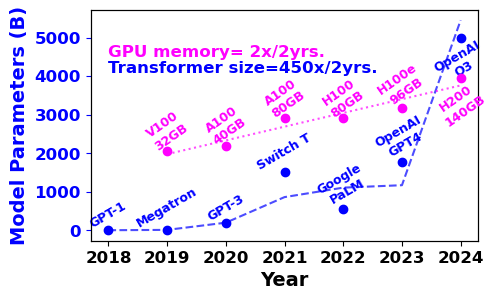

In [125]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

plt.rcParams.update({'font.size': 12})
plt.rcParams.update({'font.weight': 'bold'})
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42

# Data
models = [
    (2018, "GPT-1", 0.11),
    (2019, "Megatron", 8.3),
    (2020, "GPT-3", 175),
    (2021, "Switch T", 1500),
    (2022, "Google\nPaLM", 540),
    (2023, "OpenAI\nGPT4", 1760),
    (2024, "OpenAI\nO3", 5000)
]

gpus = [
    (2019, "V100", 32), (2020, "A100", 40), (2021, "A100", 80),
    (2022, "H100", 80), (2023, "H100e", 96), (2024, "H200", 140)
]
color1="blue"
color2="magenta"

# Extracting data
years_models, model_names, model_params = zip(*models)
years_gpus, gpu_names, gpu_memory = zip(*gpus)

# Convert data to numpy arrays for regression
years_models_np = np.array(years_models)
model_params_np = np.array(model_params)

years_gpus_np = np.array(years_gpus)
gpu_memory_np = np.array(gpu_memory)

# Fit regression lines (log scale for models)
model_coeffs = np.polyfit(years_models_np, np.log10(model_params_np), 3)
gpu_coeffs = np.polyfit(years_gpus_np, gpu_memory_np, 1)

model_trend = 10 ** np.polyval(model_coeffs, years_models_np)  # Convert back from log scale
gpu_trend = np.polyval(gpu_coeffs, years_gpus_np)

# Plot
fig, ax1 = plt.subplots(figsize=(5, 3))

# Scatter plot for model sizes
ax1.scatter(years_models, model_params, color=color1, label="Model Parameters (B)")
ax1.plot(years_models_np, model_trend, linestyle="dashed", color=color1, alpha=0.7, label="Model Growth Trend")

# Annotate model points
for i, txt in enumerate(model_names):
    va = "top"
    if (years_models[i]) <= 2023:
        va = "bottom"
    ax1.annotate(txt, (years_models[i], model_params[i]), fontsize=9, color=color1, 
                 ha="center", va=va, rotation=30)

ax1.set_ylabel("Model Parameters (B)", color=color1, fontsize=14, fontweight='bold',)
# ax1.set_yscale("log")  # Log scale for large variations
ax1.tick_params(axis='y', colors=color1)

# Secondary axis for GPU memory
ax2 = ax1.twinx()
ax2.scatter(years_gpus, gpu_memory, color=color2, label="GPU Memory (GB)")
ax2.plot(years_gpus_np, gpu_trend, color=color2, linestyle="dotted", alpha=0.7, label="GPU Memory Trend")
# ax2.set_yscale("log")  # Log scale for large variations
ax2.set_ylim(-100, 240)

# Annotate GPU points
for i, txt in enumerate(gpu_names):
    va = "bottom"
    if years_gpus[i] == 2024:
        va = "top"
    ax2.annotate(f"{txt}\n{gpu_memory[i]}GB", (years_gpus[i], gpu_memory[i]-3), fontsize=9, 
                 color=color2, ha='center', va=va, rotation=35)

ax1.annotate("GPU memory= 2x/2yrs.", (2018, 4500), fontsize=12, ha="left", color=color2)
ax1.annotate("Transformer size=450x/2yrs.", (2018, 4000), fontsize=12, ha="left", va="bottom", color=color1)

# ax2.set_ylabel("GPU Memory (GB)", color='blue')
# ax2.tick_params(axis='y', colors='blue')
ax2.set_yticks([])

# Labels and title
ax1.set_xlabel("Year", fontsize=14, fontweight='bold')

# Show plot

output_file = "model-vs-hardware"
plt.savefig(f"./plots/{output_file}.eps", format='eps', bbox_inches='tight')
plt.savefig(f"./plots/{output_file}.png", format='png', bbox_inches='tight')

plt.show()

Reading ./dl-io-outputs-test-dist-nvme-swap/act-output-40B/log-40B-tp1-dp4-l128-h5120-a40-sl2048-gbs4-mbs1-ratio1-subg100000000-pipelinerw1-opt_ratio0-cache0-skip_grads0-single_proc0-compress0-tmp.log
Reading ./dl-io-outputs-test-dist-nvme-swap/act-output-40B/log-40B-tp1-dp4-l128-h5120-a40-sl2048-gbs4-mbs1-ratio1-subg100000000-pipelinerw1-opt_ratio2-cache1-skip_grads1-single_proc1-compress0-tmp-vast.log
Reading ./dl-io-outputs-test-dist-nvme-swap-scale_dp/act-output-70B/log-70B-tp1-dp8-l80-h8192-a64-sl2048-gbs8-mbs1-ratio1-subg100000000-pipelinerw1-opt_ratio0-cache0-skip_grads0-single_proc0-compress0-local.log
Reading ./dl-io-outputs-test-dist-nvme-swap-scale_dp/act-output-70B/log-70B-tp1-dp8-l80-h8192-a64-sl2048-gbs8-mbs1-ratio1-subg100000000-pipelinerw1-opt_ratio2-cache1-skip_grads1-single_proc1-compress0-local-eagle.log
Reading ./dl-io-outputs-test-dist-nvme-swap-scale_dp/act-output-100B/log-100B-tp1-dp12-l88-h9216-a72-sl2048-gbs12-mbs1-ratio1-subg100000000-pipelinerw1-opt_ratio0-ca

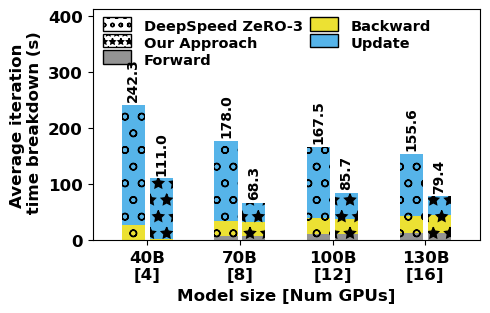

In [62]:
###############################################################
# Plot for scalability
###############################################################
def plot_scalability(config, data):
    output_file = f"./plots/scalability"
    
    group_labels = list(data.keys())
    bar_labels = list(data[group_labels[0]].keys())
    bar_width = 0.3
    bar_gap = -0.05
    xrange = np.arange(len(group_labels))

    fig, ax = plt.subplots(figsize=(5, 3))
#     ax2 = ax.twinx()
    start_offset = -0.5
    offset = start_offset
    iter_time = {}
    fwd_time = {}
    bwd_time = {}
    step_time = {}
    
    # Add the legend for hatches first
    for i, blabel in enumerate(bar_labels):
        label = approach_code[blabel]
        ax.bar(xrange, np.zeros(len(xrange)), label=label, hatch=hatches[i], color='white')
    
    # Plot the bars
    for i, blabel in enumerate(bar_labels):
        try:
            print("Computing ", blabel)
            iter_time[blabel] = [get_avg(data[glabel][blabel]['iter_time']) for glabel in group_labels]
            fwd_time[blabel] = [get_avg(data[glabel][blabel]['fwd'])/1e3 for glabel in group_labels]
            bwd_time[blabel] = [get_avg(data[glabel][blabel]['bwd'])/1e3 for glabel in group_labels]
            step_time[blabel] = [get_avg(data[glabel][blabel]['step'])/1e3 for glabel in group_labels]
        except Exception as e:
            print(f"Error for {blabel}")
        
        bottom = np.zeros(len(fwd_time[blabel]))
        ax.bar(xrange + offset * bar_width, fwd_time[blabel], bar_width+bar_gap, 
               label=f'Forward', bottom=bottom, color=FWD_TIME_COLOR, hatch=hatches[i])
        bottom += fwd_time[blabel]
        ax.bar(xrange + offset * bar_width, bwd_time[blabel], bar_width+bar_gap, 
               label=f'Backward', bottom=bottom, color=BWD_TIME_COLOR, hatch=hatches[i])
        bottom += bwd_time[blabel]
        ax.bar(xrange + offset * bar_width, step_time[blabel], bar_width+bar_gap, 
               label=f'Update', bottom=bottom, color=STEP_TIME_COLOR, hatch=hatches[i])
        offset += 1
    
    # Annotate the bars
    max_y = 0
    for j, glabel in enumerate(group_labels):
        offset = start_offset
        for i, blabel in enumerate(bar_labels):
            value = iter_time[blabel][j]
            max_y = max(max_y, value)
            ax.annotate(f'{value:.1f}', (xrange[j] + offset * bar_width, value + 5), 
                        ha='center', va='bottom', rotation=90, fontsize=10, fontweight='bold', zorder=100)
            offset += 1
    
    ax.set_ylabel('Average iteration\n time breakdown (s)', fontsize=12, fontweight='bold')
    ax.set_xlabel('Model size [Num GPUs]', fontsize=12, fontweight='bold')
    ax.set_xticks(xrange)
    ax.set_xticklabels([f"{x}B\n[{model_nodes[x]*4}]" for i, x in enumerate(group_labels)])
    ax.set_ylim(top=max_y*1.7)
    # Plot the TFLOPs on secondary y-axis
#     tflops = {}
#     for i, blabel in enumerate(bar_labels):
#         tflops[blabel] = [get_avg(data[glabel][blabel]['TFLOPs']) for glabel in group_labels]
#         ax2.plot(xrange, tflops[blabel], color='blue', marker=markers[i], linestyle=linestyles[i],
#                  markersize=10, markerfacecolor=colors[i], markeredgecolor=colors[i], zorder=1)
#     ax2.tick_params(axis='y', color='blue', labelcolor='blue')
#     ax2.spines['right'].set_color('blue')
#     ax2.set_ylabel('TFLOPs (lines)', fontsize=12, fontweight='bold', color='blue')    
#     ax2.set_ylim(bottom=-20)

    handles, labels = ax.get_legend_handles_labels()
    labels = labels[:len(bar_labels)+3]
    legends = ax.legend(handles, labels, 
                        ncol=2, frameon=False, fontsize=10.5, loc='upper left',
             borderpad=0.2, labelspacing=0.2, columnspacing=0.5, ) 
    for i, handle in enumerate(legends.get_patches()):
        handle.set_edgecolor('black')
        handle.set_height(10)
        handle.set_width(20)
        if i < len(bar_labels):
            handle.set_hatch(handle.get_hatch()*2)
        else:
            handle.set_hatch(None)

    
    plt.savefig(f"{output_file}.eps", format='eps', bbox_inches='tight')
    plt.savefig(f"{output_file}.png", format='png', bbox_inches='tight')
    plt.show()


res = {}
model_nodes = {40: 1, 70: 2, 100: 3, 130: 4, 280: 8}
for mi, model in enumerate([40, 70, 100, 130]):
    config = copy.deepcopy(base_config)
    res[model] = {}
    for k in [0, 9]:
        res[model][k] = None
        config['basepath'] = f"./dl-io-outputs-test-dist-nvme-swap-scale_dp/act-output-{model}B"
        config['opt_gaps'] = k
        config['dp'] = 4 * model_nodes[model]
        config['mbs'] = 1
        config['tp'] = 1
        config['gbs'] = config['mbs']*config['dp']
        # print("Got config as ", config)
        ans = None
        config['approach'] = approach_code[k]
        
        if k==0:
            config['cache'] = 0
            config['skip_grads'] = 0
            config['opt_ratio'] = 0
            config['fs'] = "local"
        elif k == 5:
            config['approach'] = approach_code[k]
            config['cache'] = 1
            config['skip_grads'] = 0
            config['opt_ratio'] = 2
            config['fs'] = "local-eagle"
        elif k == 9:
            config['cache'] = 1
            config['skip_grads'] = 1
            config['opt_ratio'] = 2
            config['fs'] = "local-eagle"
            config['compress'] = 0
            config['single_proc'] = 1
        else:
            print("Undefined K... Returning")
            import pdb; pdb.set_trace()
        if model == 40:
            config['basepath'] = f"./dl-io-outputs-test-dist-nvme-swap/act-output-{model}B"
            if k == 0:
                config['fs'] = "tmp"
            else:
                config["fs"] = "tmp-vast"
        ans = parse_log(MODELS[model], config)
        res[model][k] = ans

plot_scalability(config, res)

Reading ./dl-io-outputs-test-dist-nvme-swap/act-output-40B/log-40B-tp1-dp4-l128-h5120-a40-sl2048-gbs4-mbs1-ratio1-subg100000000-pipelinerw1-opt_ratio0-cache0-skip_grads0-single_proc0-compress0-tmp.log
Reading ./dl-io-outputs-test-dist-nvme-swap/act-output-40B/log-40B-tp1-dp4-l128-h5120-a40-sl2048-gbs4-mbs1-ratio1-subg100000000-pipelinerw1-opt_ratio2-cache1-skip_grads1-single_proc1-compress0-tmp-vast.log
Reading ./dl-io-outputs-test-dist-nvme-swap-scale_dp/act-output-70B/log-70B-tp1-dp8-l80-h8192-a64-sl2048-gbs8-mbs1-ratio1-subg100000000-pipelinerw1-opt_ratio0-cache0-skip_grads0-single_proc0-compress0-local.log
Reading ./dl-io-outputs-test-dist-nvme-swap-scale_dp/act-output-70B/log-70B-tp1-dp8-l80-h8192-a64-sl2048-gbs8-mbs1-ratio1-subg100000000-pipelinerw1-opt_ratio2-cache1-skip_grads1-single_proc1-compress0-local-eagle.log
Reading ./dl-io-outputs-test-dist-nvme-swap-scale_dp/act-output-100B/log-100B-tp1-dp12-l88-h9216-a72-sl2048-gbs12-mbs1-ratio1-subg100000000-pipelinerw1-opt_ratio0-ca

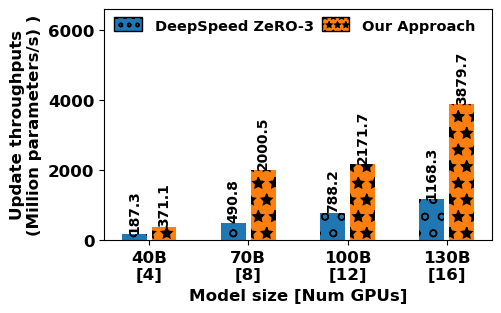

In [56]:
###############################################################
# Plot for scalability update throughuputs
###############################################################
def plot_scalability_update_thru(config, data):
    output_file = f"./plots/scalability_update_thru"
    
    group_labels = list(data.keys())
    bar_labels = list(data[group_labels[0]].keys())
    bar_width = 0.3
    bar_gap = -0.05
    xrange = np.arange(len(group_labels))

    fig, ax = plt.subplots(figsize=(5, 3))
#     ax2 = ax.twinx()
    start_offset = -0.5
    offset = start_offset
    iter_time = {}
    fwd_time = {}
    bwd_time = {}
    step_time = {}
        
    # Plot the bars
    for i, blabel in enumerate(bar_labels):
        try:
            print("Computing ", blabel)
            iter_time[blabel] = [glabel/(get_avg(data[glabel][blabel]['step'])/1e6) for glabel in group_labels]
            step_time[blabel] = [glabel/(get_avg(data[glabel][blabel]['step'])/1e6) for glabel in group_labels]
        except Exception as e:
            print(f"Error for {blabel}")
        label = approach_code[blabel]
        ax.bar(xrange + offset * bar_width, step_time[blabel], bar_width+bar_gap, hatch=hatches[i], label=label)
        offset += 1
    
    # Annotate the bars
    max_y = 0
    for j, glabel in enumerate(group_labels):
        offset = start_offset
        for i, blabel in enumerate(bar_labels):
            value = iter_time[blabel][j]
            max_y = max(max_y, value)
            ax.annotate(f'{value:.1f}', (xrange[j] + offset * bar_width, value + 15), 
                        ha='center', va='bottom', rotation=90, fontsize=10, fontweight='bold', zorder=100)
            offset += 1
    
    ax.set_ylabel('Update throughputs\n(Million parameters/s) )', fontsize=12, fontweight='bold')
    ax.set_xlabel('Model size [Num GPUs]', fontsize=12, fontweight='bold')
    ax.set_xticks(xrange)
    ax.set_xticklabels([f"{x}B\n[{model_nodes[x]*4}]" for i, x in enumerate(group_labels)])
    ax.set_ylim(top=max_y*1.7)
    # Plot the TFLOPs on secondary y-axis
#     tflops = {}
#     for i, blabel in enumerate(bar_labels):
#         tflops[blabel] = [get_avg(data[glabel][blabel]['TFLOPs']) for glabel in group_labels]
#         ax2.plot(xrange, tflops[blabel], color='blue', marker=markers[i], linestyle=linestyles[i],
#                  markersize=10, markerfacecolor=colors[i], markeredgecolor=colors[i], zorder=1)
#     ax2.tick_params(axis='y', color='blue', labelcolor='blue')
#     ax2.spines['right'].set_color('blue')
#     ax2.set_ylabel('TFLOPs (lines)', fontsize=12, fontweight='bold', color='blue')    
#     ax2.set_ylim(bottom=-20)

    handles, labels = ax.get_legend_handles_labels()
    labels = labels[:len(bar_labels)+3]
    legends = ax.legend(handles, labels, 
                        ncol=2, frameon=False, fontsize=10.5, loc='upper left',
             borderpad=0.2, labelspacing=0.2, columnspacing=0.5, ) 
    for i, handle in enumerate(legends.get_patches()):
        handle.set_edgecolor('black')
        handle.set_height(10)
        handle.set_width(20)
        if i < len(bar_labels):
            handle.set_hatch(handle.get_hatch()*2)
        else:
            handle.set_hatch(None)

    
    plt.savefig(f"{output_file}.eps", format='eps', bbox_inches='tight')
    plt.savefig(f"{output_file}.png", format='png', bbox_inches='tight')
    plt.show()


res = {}
model_nodes = {40: 1, 70: 2, 100: 3, 130: 4, 280: 8}
for mi, model in enumerate([40, 70, 100, 130]):
    config = copy.deepcopy(base_config)
    res[model] = {}
    for k in [0, 9]:
        res[model][k] = None
        config['basepath'] = f"./dl-io-outputs-test-dist-nvme-swap-scale_dp/act-output-{model}B"
        config['opt_gaps'] = k
        config['dp'] = 4 * model_nodes[model]
        config['mbs'] = 1
        config['tp'] = 1
        config['gbs'] = config['mbs']*config['dp']
        # print("Got config as ", config)
        ans = None
        config['approach'] = approach_code[k]
        
        if k==0:
            config['cache'] = 0
            config['skip_grads'] = 0
            config['opt_ratio'] = 0
            config['fs'] = "local"
        elif k == 5:
            config['approach'] = approach_code[k]
            config['cache'] = 1
            config['skip_grads'] = 0
            config['opt_ratio'] = 2
            config['fs'] = "local-eagle"
        elif k == 9:
            config['cache'] = 1
            config['skip_grads'] = 1
            config['opt_ratio'] = 2
            config['fs'] = "local-eagle"
            config['compress'] = 0
            config['single_proc'] = 1
        else:
            print("Undefined K... Returning")
            import pdb; pdb.set_trace()
        if model == 40:
            config['basepath'] = f"./dl-io-outputs-test-dist-nvme-swap/act-output-{model}B"
            if k == 0:
                config['fs'] = "tmp"
            else:
                config["fs"] = "tmp-vast"
        ans = parse_log(MODELS[model], config)
        res[model][k] = ans

plot_scalability_update_thru(config, res)

Reading ./dl-io-outputs-test-dist-nvme-swap/act-output-20B/log-20B-tp1-dp4-l40-h5120-a64-sl2048-gbs4-mbs1-ratio1-subg100000000-pipelinerw1-opt_ratio0-cache0-skip_grads0-single_proc0-compress0-tmp-cpu.log for 20
Reading ./dl-io-outputs-test-dist-nvme-swap/act-output-20B/log-20B-tp1-dp4-l40-h5120-a64-sl2048-gbs4-mbs1-ratio1-subg100000000-pipelinerw1-opt_ratio0-cache0-skip_grads0-single_proc0-compress0-tmp.log for 20
Reading ./dl-io-outputs-test-dist-nvme-swap/act-output-40B/log-40B-tp1-dp4-l128-h5120-a40-sl2048-gbs4-mbs1-ratio1-subg100000000-pipelinerw1-opt_ratio0-cache0-skip_grads0-single_proc0-compress0-tmp.log for 40
Reading ./dl-io-outputs-test-dist-nvme-swap/act-output-70B/log-70B-tp1-dp4-l80-h8192-a64-sl2048-gbs4-mbs1-ratio1-subg100000000-pipelinerw1-opt_ratio0-cache0-skip_grads0-single_proc0-compress0-tmp.log for 70
Reading ./dl-io-outputs-test-dist-nvme-swap/act-output-120B/log-120B-tp1-dp4-l96-h10240-a80-sl2048-gbs4-mbs1-ratio1-subg100000000-pipelinerw1-opt_ratio0-cache0-skip_gr

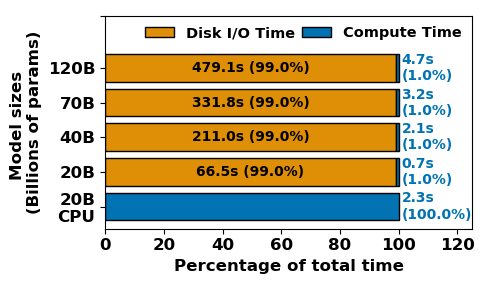

In [51]:
###############################################################
# Plot for wait times of different models.
###############################################################


def parse_logs_waits(filename):
    with open(filename, 'r') as f:
        log_data = f.read()

    # Find the third and fourth occurrences of "TFLOPs"
    tflops_occurrences = [m.start() for m in re.finditer(r'TFLOPs', log_data)]
    if len(tflops_occurrences) < 2:
        raise ValueError("Log file does not contain at least 4 occurrences of 'TFLOPs'.")
    
    relevant_section = log_data[tflops_occurrences[0]:tflops_occurrences[1]]
    

    # Regex to extract *_wait values
    wait_pattern = re.compile(r'(read_wait|write_wait|compute_wait)\[\d+\]\[\d+\]: ([\d\.]+)')
    waits = {'read_wait': 0, 'write_wait': 0, 'compute_wait': 0}
    rank_counts = set()  # Track unique ranks

    for match in wait_pattern.finditer(relevant_section):
        wait_type, value = match.groups()
        waits[wait_type] += float(value)
        rank = re.search(r'\[(\d+)\]', match.group(0)).group(1)
        rank_counts.add(rank)
    
    # Average over ranks
    num_ranks = len(rank_counts)
    
    for key in waits:
        waits[key] /= num_ranks

    ### BAD HACK!!!
    if "cpu.log" in filename:
        waits["read_wait"] = waits["write_wait"] = 0
        waits["compute_wait"] = 2.274

    return waits, num_ranks




def plot_wait_times(wait_times_dict):
    """
    Create a horizontal 100% stacked bar plot for multiple model sizes with normalized I/O and compute times.
    Display both time in seconds and percentage inside the bars.
    """
    output_file = "./plots/motivation-wait-time"
    # Prepare data
    model_sizes = list(wait_times_dict.keys())
    io_times = []
    compute_times = []
    for waits in wait_times_dict.values():
        io_times.append(waits['read_wait'] + waits['write_wait'])
        compute_times.append(waits['compute_wait'])
    
    total_times = [io + compute for io, compute in zip(io_times, compute_times)]

    # Normalize times to 100%
    io_percentages = [io / total * 100 for io, total in zip(io_times, total_times)]
    compute_percentages = [compute / total * 100 for compute, total in zip(compute_times, total_times)]

    # Create the bar chart
    fig, ax = plt.subplots(figsize=(5, 3))
    y_pos = range(len(model_sizes))  # Positions for the bars

    # Plot normalized bars for I/O and Compute times
    ax.barh(y_pos, io_percentages, color=colors[3], edgecolor='black', label='Disk I/O Time')
    ax.barh(y_pos, compute_percentages, color=colors[2], edgecolor='black', left=io_percentages, label='Compute Time')

    # Add labels for each bar
    for i, (io, compute, total) in enumerate(zip(io_times, compute_times, total_times)):
        io_percentage = io / total * 100
        compute_percentage = compute / total * 100
        # I/O label
        if io_percentage > 0.1:
            ax.text(io_percentage / 2, i, f"{io:.1f}s ({io_percentage:.1f}%)", 
                    va='center', ha='center', color='black', fontsize=10)
        # Compute label
        ax.text(io_percentage + compute_percentage + 1, i, f"{compute:.1f}s\n({compute_percentage:.1f}%)", 
                va='center', ha='left', color=colors[2], fontsize=10)

    # Customize plot
    #ax.set_yticks(y_pos)
    ax.set_xlim(right=125)
    ax.set_yticks(list(range(len(model_sizes))) + [len(model_sizes)*1.1])
    ytick_vals = []
    for size in model_sizes:
        if isinstance(size, str) and "CPU" in size:
            ms = size.split("-")[0]
            ytick_vals.append(f"{ms}B\nCPU")
        else:
            ytick_vals.append(f"{size}B")
    ytick_vals.append(" ")
    ax.set_yticklabels(ytick_vals)
    ax.set_xlabel("Percentage of total time", fontsize=12, fontweight='bold')
    ax.set_ylabel("Model sizes \n(Billions of params)", fontsize=12, fontweight='bold')
    ax.legend(ncol=2, frameon=False, fontsize=10.5, borderpad=0.2, labelspacing=0.2, columnspacing=0.5,)
    plt.tight_layout()
    plt.savefig(f"{output_file}.eps", format='eps', bbox_inches='tight')
    plt.savefig(f"{output_file}.png", format='png', bbox_inches='tight')
    plt.show()


    
res = {}
for model in ["20-CPU", 20, 40, 70, 120]:
    config = copy.deepcopy(base_config)
    model_name = model
    is_cpu = False
    if isinstance(model, str) and "CPU" in model:
        model = int(model_name.split("-")[0])
        is_cpu = True
    res[model_name] = {}
    for k in [0]:
        res[model_name] = None
        config['basepath'] = f"./dl-io-outputs-test-dist-nvme-swap/act-output-{model}B"
        config['opt_gaps'] = k
        config['dp'] = 4
        config['mbs'] = 1
        config['tp'] = 1
        config['gbs'] = config['mbs']*config['dp']
        # print("Got config as ", config)
        ans = None
        config['approach'] = approach_code[k]
        if k==0:
            config['cache'] = 0
            config['skip_grads'] = 0
            config['opt_ratio'] = 0
        elif k == 5:
            config['approach'] = approach_code[k]
            config['cache'] = 1
            config['skip_grads'] = 0
            config['opt_ratio'] = 2
            config['fs'] = "tmp-vast"
        elif k == 9:
            config['cache'] = 1
            config['skip_grads'] = 1
            config['opt_ratio'] = 3
            config['fs'] = "tmp-vast"
            config['compress'] = 1
            config['single_proc'] = 1
        elif model_name != model:
            config['approach'] = "CPU only offload"
            config['cache'] = 0
            config['skip_grads'] = 0
            config['opt_ratio'] = 0
            config['fs'] = "tmp-cpu"
        else:
            print("Undefined K... Returning")
            import pdb; pdb.set_trace()
        filename = get_filename(MODELS[model], config)
        if is_cpu:
            filename = filename.replace(".log", "-cpu.log")
        print(f"Reading {filename} for {model}")
        ans, num_ranks = parse_logs_waits(filename)
        res[model_name] = ans
            
print(res)        
plot_wait_times(res)

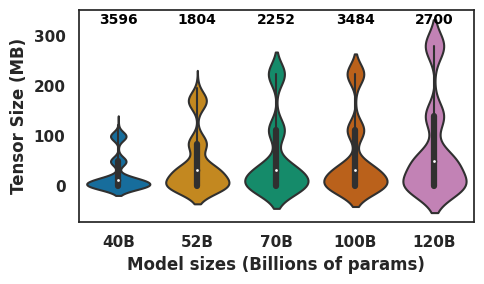

In [337]:
###############################################################
# Plot the size of params for gradient buffer (causing fragmentation, alignment, etc. to bloat memory)
###############################################################

def parse_log_files_grad_sizes(log_file):
    tensor_regex = re.compile(r"#params: (\d+), dtype=torch\.\w+")
    tensor_sizes = []
    per_element_size = 2
    norm_MB = (1024**2)
    with open(log_file, 'r') as file:
        for line in file:
            match = tensor_regex.search(line)
            if match:
                size = int(match.group(1))
                tensor_sizes.append(size*per_element_size/norm_MB)

    return tensor_sizes

def plot_tensor_sizes(tensor_sizes):
    # Prepare data for plotting
    output_file = "./plots/grad-fragmentation"
    num_ranks = 4
    data = []
    for model_size, sizes in tensor_sizes.items():
        for size in sizes:
            data.append({"Model": f"{model_size}B", "Tensor Size": size})

    df = pd.DataFrame(data)

    # Plot violin plot
    fig, ax = plt.subplots(figsize=(5, 3))
    sns.violinplot(ax=ax, data=df, x="Model", y="Tensor Size", scale='width')
     # Annotate total number of tensors for each model
    for i, model in enumerate(tensor_sizes.keys()):
        total_tensors = len(tensor_sizes[model])*num_ranks
        ax.text(i, max(df['Tensor Size'])+38, f'{total_tensors}', 
                horizontalalignment='center', verticalalignment='bottom', fontsize=10, color='black')
    ax.set_xlabel("Model sizes (Billions of params)", fontsize=12, fontweight='bold')
    ax.set_ylabel("Tensor Size (MB)", fontsize=12, fontweight='bold')
    plt.tight_layout()
    plt.savefig(f"{output_file}.eps", format='eps', bbox_inches='tight')
    plt.savefig(f"{output_file}.png", format='png', bbox_inches='tight')
    plt.show()

res = {}
for model in [40, 52, 70, 100, 120]:
    config = copy.deepcopy(base_config)
    res[model] = {}
    for k in [0]:
        res[model] = None
        config['basepath'] = f"./dl-io-outputs-test-dist-nvme-swap-cpu_mem_consumption/act-output-{model}B"
        config['opt_gaps'] = k
        config['dp'] = 4
        config['mbs'] = 1
        config['tp'] = 1
        config['gbs'] = config['mbs']*config['dp']
        ans = None
        config['approach'] = approach_code[k]
        if k==0:
            config['cache'] = 0
            config['skip_grads'] = 0
            config['opt_ratio'] = 0
            config['pipelinerw'] = 0
        else:
            print("Undefined K... Returning")
            import pdb; pdb.set_trace()
        filename = get_filename(MODELS[model], config)
        res[model] = parse_log_files_grad_sizes(filename)
plot_tensor_sizes(res)


/tmp/ipykernel_10680/1525937538.py:91: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_xticklabels(x_labels + x_labels, minor=True)


major [0 1 2] 1.0


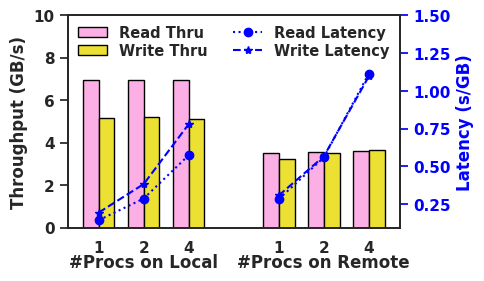

In [377]:
###############################################################
# Plot for the disk read/write speed for 1 thread diff number of processes
###############################################################


def plot_throughput_and_latency():
    output_file = "./plots/motivation-disk-thru"
    data = {
        "local": {
            "read": {
                "processes": [1, 2, 4],
                "throughput": [6.939088024, 6.958561073, 6.963748463],
                "latency": [0.1441111565, 0.2874157429, 0.574403286],
            },
            "write": {
                "processes": [1, 2, 4],
                "throughput": [5.141458308, 5.217769484, 5.129324764],
                "latency": [0.1944973469, 0.3833055496, 0.7798297405],
            },
        },
        "remote": { # threads=4
            "read": {
                "processes": [1, 2, 4],
                "throughput": [3.52, 3.57, 3.59],
                "latency": [0.2833, 0.559, 1.1131],
            },
            "write": {
                "processes": [1, 2, 4],
                "throughput": [3.24, 3.53, 3.65],
                "latency": [0.3077, 0.5658, 1.095],
            },
        },
    }

    processes = [1, 2, 4]
    x_labels = ["1", "2", "4"]
    width = 0.35  # Width of bars

    fig, ax1 = plt.subplots(figsize=(5, 3))

    # Positions for bars
    x_local = np.arange(len(processes))
    x_remote = x_local + (len(processes) + 1)  # Offset for remote

    # Plot throughput
    READ_COLOR = orig_colors[6]
    WRITE_COLOR = orig_colors[8]
    MARKER_COLOR = "black"
    ax1.bar(
        x_local - width / 2,
        data["local"]["read"]["throughput"],
        width,
        label="Read Thru",
        edgecolor=MARKER_COLOR,
        color=READ_COLOR,
#         hatch="O",
    )
    ax1.bar(
        x_local + width / 2,
        data["local"]["write"]["throughput"],
        width,
        label="Write Thru",
        edgecolor=MARKER_COLOR,
        color=WRITE_COLOR,
#         hatch="*",
    )
    ax1.bar(
        x_remote - width / 2,
        data["remote"]["read"]["throughput"],
        width,
        edgecolor=MARKER_COLOR,
        color=READ_COLOR,
#         hatch="O",
    )
    ax1.bar(
        x_remote + width / 2,
        data["remote"]["write"]["throughput"],
        width,
        edgecolor=MARKER_COLOR,
        color=WRITE_COLOR,
#         hatch="*",
    )

    ax1.set_ylabel("Throughput (GB/s)", fontsize=12, fontweight='bold')
    ax1.set_xticks(np.concatenate([x_local, x_remote]))
    ax1.set_xticklabels(["1", "2", "4", "1", "2", "4"])
    ax1.set_ylim(top=10)

    # Add second layer of x-ticks
    ax1.tick_params(axis="x", which="both", bottom=False, top=False)
    ax1.set_xticklabels(x_labels + x_labels, minor=True)
    ax1.tick_params(axis="x", which="minor", length=0)
    ax1.text(np.mean(x_local), -1.2, "#Procs on Local", ha="center", va="top", fontsize=12)
    ax1.text(np.mean(x_remote), -1.2, "#Procs on Remote", ha="center", va="top", fontsize=12)

    # Secondary axis for latency
    ax2 = ax1.twinx()
    ax2.plot(
        x_local,
        data["local"]["read"]["latency"],
        linestyle="dotted",
        color="blue",
        marker="o",
        label="Read Latency",
    )
    ax2.plot(
        x_local,
        data["local"]["write"]["latency"],
        linestyle="dashed",
        color="blue",
        marker="*",
        label="Write Latency",
    )
    ax2.plot(
        x_remote,
        data["remote"]["read"]["latency"],
        linestyle="dotted",
        color="blue",
        marker="o"
    )
    ax2.plot(
        x_remote,
        data["remote"]["write"]["latency"],
        linestyle="dashed",
        color="blue",
        marker="*"
    )

    ax2.set_ylabel("Latency (s/GB)", color="blue", fontsize=12, fontweight='bold')
    ax2.tick_params(axis="y", colors="blue")
    ax2.set_ylim(top=1.5)

    ax1.legend(loc="upper left", frameon=False, fontsize=10.5, borderpad=0.2, labelspacing=0.2, columnspacing=0.5,)
    ax2.legend(loc="upper right", frameon=False, fontsize=10.5, borderpad=0.2, labelspacing=0.2, columnspacing=0.5,)

    plt.tight_layout()
    plt.savefig(f"{output_file}.eps", format='eps', bbox_inches='tight')
    plt.savefig(f"{output_file}.png", format='png', bbox_inches='tight')
    plt.show()



# Call the function
plot_throughput_and_latency()

4 152047616 4


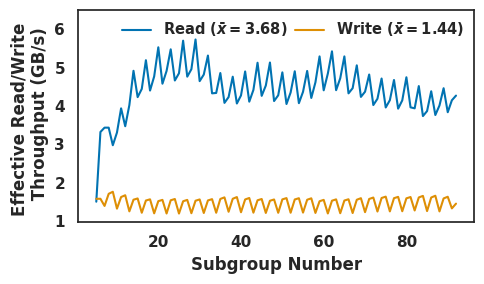

In [437]:
###############################################################
# Plot the apparent wait time per subgroup for I/O operations
###############################################################
def parse_log_file(filepath):
    with open(filepath, 'r') as file:
        log_data = file.readlines()

    # Initialize necessary variables
    iter_count = 0
    start_parsing = False
    wait_times = defaultdict(lambda: defaultdict(list))
    largest_numel = None
    swap_element_size = None
    dist_opt_grad_skip = False
    subgroup_size = 4  # Default to 4; will update if `dist_opt_grad_skip=True` is found
    num_subgroups = 0
    num_ranks = 0

    # Read the log file line by line
    for line in log_data:
        # Find `largest_numel`, `swap_element_size`, and `dist_opt_grad_skip`
        largest_numel_match = re.search(r'largest_numel\s+\.*\s+(\d+)', line)
        if largest_numel_match:
            largest_numel = int(largest_numel_match.group(1))

        # Extract swap_element_size
        swap_element_size_match = re.search(r'swap_element_size\s+\.*\s+(\d+)', line)
        if swap_element_size_match:
            swap_element_size = int(swap_element_size_match.group(1))

        # Extract dist_opt_grad_skip
        if "dist_opt_grad_skip=True" in line:
            dist_opt_grad_skip = True
        # Start parsing after 3rd iteration marker
        if '<<<iter_marker:' in line:
            iter_count += 1
            if iter_count >= 3:
                start_parsing = True
            continue

        # Parse wait times after the 3rd marker
        if start_parsing:
            # Use regex to find all occurrences of *_wait[rank][subgroup]: time_value
            matches = re.findall(r'(\w+_wait)\[(\d+)\]\[(\d+)\]: ([\d.]+)', line)
            for match in matches:
                wait_type = match[0]     # Type of wait (read_wait, compute_wait, write_wait)
                rank = int(match[1])     # Rank number (process ID)
                num_ranks = max(num_ranks, rank+1)
                subgroup = int(match[2]) # Subgroup ID
                num_subgroups = max(num_subgroups, subgroup)
                time_value = float(match[3])  # Time in seconds

                # Store the time values
                wait_times[(rank, subgroup)][wait_type].append(time_value)

    # Discard the first two occurrences and calculate averages
    average_waits = defaultdict(lambda: {'read_wait': 0, 'compute_wait': 0, 'write_wait': 0})
    num_samples = 0
    for (rank, subgroup), times in wait_times.items():
        for wait_type in ['read_wait', 'compute_wait', 'write_wait']:
            # Exclude the first two entries for warm-up and calculate the average
            valid_times = times[wait_type][:]  # Skip first two occurrences
            if valid_times:
                average_waits[(rank, subgroup)][wait_type] = sum(valid_times) / len(valid_times)
                num_samples = max(num_samples, len(valid_times))

    # Calculate the size of each subgroup in bytes
    subgroup_size_bytes = subgroup_size * largest_numel * swap_element_size if largest_numel and swap_element_size else None
    print(subgroup_size, largest_numel, swap_element_size)

    # Convert results to a DataFrame
    results = []
    for (rank, subgroup), averages in average_waits.items():
        results.append({
            'rank': rank,
            'subgroup': subgroup,
            'read_wait_avg': averages['read_wait'],
            'compute_wait_avg': averages['compute_wait'],
            'write_wait_avg': averages['write_wait'],
            'num_samples': num_samples
        })

    df = pd.DataFrame(results)
    res = {"subgroup_size_bytes": subgroup_size_bytes * num_subgroups * num_ranks}
    return df, subgroup_size_bytes


def plot_throughputs(df, subgroup_size_bytes, smoothing_interval=10):
    output_file = "./plots/motivation-per-subgroup-rw-thru"
    # Group by 'subgroup' to find the average wait times across all ranks
    avg_waits = df.groupby('subgroup').mean()[['read_wait_avg', 'compute_wait_avg', 'write_wait_avg']]
    
    # Apply rolling smoothing on averaged wait times across ranks
    avg_waits['smoothed_read_wait'] = avg_waits['read_wait_avg'].rolling(window=smoothing_interval, center=True).mean()
    avg_waits['smoothed_compute_wait'] = avg_waits['compute_wait_avg'].rolling(window=smoothing_interval, center=True).mean()
    avg_waits['smoothed_write_wait'] = avg_waits['write_wait_avg'].rolling(window=smoothing_interval, center=True).mean()

    # Calculate throughput in GB/s for each smoothed wait time
    num_ranks = df['rank'].nunique()  # Number of ranks
    avg_waits['read_throughput'] = (subgroup_size_bytes) / (avg_waits['smoothed_read_wait'] * (1024 ** 3))
    avg_waits['compute_throughput'] = (subgroup_size_bytes) / (avg_waits['smoothed_compute_wait'] * (1024 ** 3))
    avg_waits['write_throughput'] = (subgroup_size_bytes) / (avg_waits['smoothed_write_wait'] * (1024 ** 3))

    # Calculate overall mean throughput
    num_subgroups = df['subgroup'].nunique()
    total_data_size = subgroup_size_bytes * num_ranks * num_subgroups / (1024 ** 3)  # Convert to GB
    total_read_wait = df['read_wait_avg'].sum()
    total_write_wait = df['write_wait_avg'].sum()
    mean_read_throughput = total_data_size / total_read_wait
    mean_write_throughput = total_data_size / total_write_wait

    # Melt the DataFrame for plotting
    melted_df = avg_waits[['read_throughput', 'write_throughput']].reset_index().melt(
        id_vars='subgroup', var_name='Type', value_name='Throughput (GB/s)'
    )

    # Plotting
    fig, ax = plt.subplots(figsize=(5, 3))
    sns.lineplot(data=melted_df, ax=ax, x='subgroup', y='Throughput (GB/s)', hue='Type')
    ax.set_xlabel('Subgroup Number', fontsize=12, fontweight='bold' )
    ax.set_ylabel('Effective Read/Write \n Throughput (GB/s)', fontsize=12, fontweight='bold')
    ax.set_ylim(top=6.5)
#     plt.legend(labels=[f"Read throughput ({mean_read_throughput:.2f})",
#                       f"Write throughput ({mean_write_throughput:.2f})"])
    handles, labels = ax.get_legend_handles_labels()
    labels = [f"Read ($\\bar{{x}}={mean_read_throughput:.2f}$)", 
              f"Write ($\\bar{{x}}={mean_write_throughput:.2f}$)"]
    legends = ax.legend(handles, labels, ncol=2, frameon=False, fontsize=10.5,
             borderpad=0.2, labelspacing=0.2, columnspacing=0.5, ) 
    plt.tight_layout()
    plt.savefig(f"{output_file}.eps", format='eps', bbox_inches='tight')
    plt.savefig(f"{output_file}.png", format='png', bbox_inches='tight')
    plt.show()

filename="dl-io-outputs-test-dist-nvme-swap/act-output-40B/log-40B-tp1-dp4-l128-h5120-a40-sl2048-gbs4-mbs1-ratio1-subg100000000-pipelinerw1-opt_ratio0-cache0-skip_grads0-single_proc0-compress0-tmp.log"
df, subgroup_size_bytes = parse_log_file(filename)
plot_throughputs(df, subgroup_size_bytes)


# filename="dl-io-outputs-test-dist-nvme-swap/act-output-40B/log-40B-tp1-dp4-l128-h5120-a40-sl2048-gbs4-mbs1-ratio1-subg100000000-pipelinerw1-opt_ratio3-cache1-skip_grads1-single_proc1-compress1-tmp-vast.log"
# df, subgroup_size_bytes = parse_log_file(filename)
# plot_throughputs(df, subgroup_size_bytes)

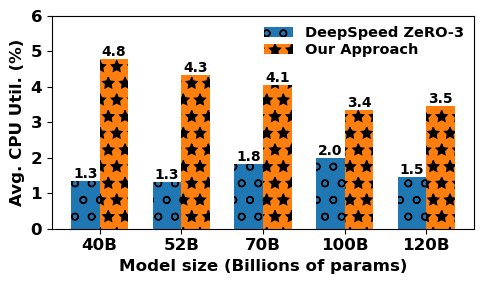

In [26]:
###############################################################
# Plot for CPU utilization of differnet models
###############################################################
def extract_and_filter_logs(deepspeed_log_path, monitoring_log_path):
    # Parse the deepspeed log file to extract the 3rd update start and stop timestamps
    with open(deepspeed_log_path, 'r') as deepspeed_file:
        deepspeed_logs = deepspeed_file.readlines()

    update_starts = []
    update_stops = []
    for line in deepspeed_logs:
        start_match = re.search(r'-> update:start:(\d+)', line)
        if start_match:
            update_starts.append(int(start_match.group(1)))
        stop_match = re.search(r'-> update:stop:(\d+)', line)
        if stop_match:
            update_stops.append(int(stop_match.group(1)))

    # Only keep the 3rd update's timestamps
    if len(update_starts) < 3 or len(update_stops) < 3:
        raise ValueError("Insufficient update start/stop timestamps in the log.")

    third_update_start = update_starts[2]
    third_update_stop = update_stops[2]

    # Parse the monitoring log file and filter entries within the timestamp range
    monitoring_data = pd.read_csv(monitoring_log_path)
    monitoring_data = monitoring_data.rename(columns=lambda x: x.strip())  # Strip whitespace in column names

    # Filter rows based on the timestamp range
    filtered_data = monitoring_data[
        (monitoring_data['timestamp'] >= third_update_start) & 
        (monitoring_data['timestamp'] <= third_update_stop)
    ]

    return filtered_data

def plot_cpu_utilization(res):
    output_file = "./plots/avg-cpu-util-compare"
    # Extract models and approaches
    models = sorted(res.keys())
    approaches = sorted(list(res[models[0]].keys()))  # Assuming all models have the same keys
    num_approaches = len(approaches)

    # Prepare data for plotting
    avg_cpu_utilization = []
    for model in models:
        model_utilization = []
        for approach in approaches:
            if res[model][approach] is not None:
                model_utilization.append(res[model][approach]['cpu_utilization'])
            else:
                model_utilization.append(0)  # Default to 0 if data is missing
        avg_cpu_utilization.append(model_utilization)

    # Convert to numpy array for easier manipulation
    avg_cpu_utilization = np.array(avg_cpu_utilization)

    # Plotting
    x = np.arange(len(models))  # X-ticks positions
    bar_width = 0.35  # Width of each bar
    fig, ax = plt.subplots(figsize=(5, 3))

    # Plot bars for each approach
    for i, approach in enumerate(approaches):
        bars = ax.bar(x + i * bar_width, avg_cpu_utilization[:, i], bar_width, label=f'{approach_code[approach]}', hatch=hatches[i])
        for bar in bars:
            height = bar.get_height()
            ax.text(
                bar.get_x() + bar.get_width() / 2, 
                height, 
                f'{height:.1f}', 
                ha='center', 
                va='bottom', 
                fontsize=10
            )
    ax.set_ylim(top=6)
    # Customize the plot
    ax.set_xlabel('Model size (Billions of params)', fontsize=12, fontweight="bold")
    ax.set_ylabel('Avg. CPU Util. (%)', fontsize=12, fontweight="bold")
    ax.set_xticks(x + (num_approaches - 1) * bar_width / 2)
    ax.set_xticklabels([f'{model}B' for model in models])
    ax.legend(frameon=False, fontsize=10.5, borderpad=0.2, labelspacing=0.2, columnspacing=0.5,)

    plt.tight_layout()
    plt.savefig(f"{output_file}.eps", format='eps', bbox_inches='tight')
    plt.savefig(f"{output_file}.png", format='png', bbox_inches='tight')
    # Show plot
    plt.show()

res = {}
for model in [40, 52, 70, 100, 120]:
    config = copy.deepcopy(base_config)
    res[model] = {}
    for k in [0, 9]:
        res[model][k] = None
        config['basepath'] = f"dl-io-outputs-test-dist-nvme-swap/act-output-{model}B"
        config['opt_gaps'] = k
        config['dp'] = 4
        config['mbs'] = 1
        config['tp'] = 1
        config['gbs'] = config['mbs']*config['dp']
        ans = None
        config['approach'] = approach_code[k]
        if k==0:
            config['cache'] = 0
            config['skip_grads'] = 0
            config['opt_ratio'] = 0
            config['pipelinerw'] = 1
        elif k == 9:
            config['cache'] = 1
            config['skip_grads'] = 1
            config['opt_ratio'] = 3
            config['fs'] = "tmp-vast"
            config['compress'] = 0
            config['single_proc'] = 1
        else:
            print("Undefined K... Returning")
            import pdb; pdb.set_trace()
        filename = get_filename(MODELS[model], config)
        monitor_log = filename.split("/")[-1]
        monitor_log = f"{config['basepath']}/monitor-{monitor_log.split('.')[0]}.csv"
        ans = extract_and_filter_logs(filename,monitor_log)
        res[model][k] = ans.mean()
        
plot_cpu_utilization(res)

In [14]:
###############################################################
# Plot for different offloading ratios
###############################################################



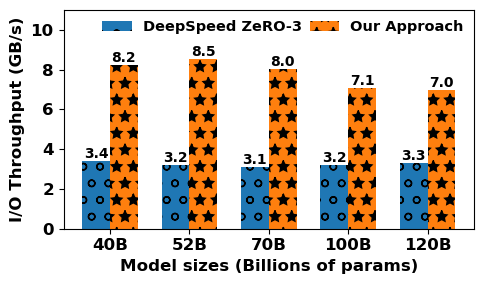

In [25]:
###############################################################
# Plot for effective read/write throughput of different models.
###############################################################

def parse_logs_waits(model_data, filename):
    with open(filename, 'r') as f:
        log_data = f.read()

    # Find the third and fourth occurrences of "TFLOPs"
    tflops_occurrences = [m.start() for m in re.finditer(r'TFLOPs', log_data)]
    if len(tflops_occurrences) < 3:
        raise ValueError("Log file does not contain at least 4 occurrences of 'TFLOPs'.")
    
    relevant_section = log_data[tflops_occurrences[0]:tflops_occurrences[1]]

    # Regex to extract *_wait values
    wait_pattern = re.compile(r'(read_wait|write_wait|compute_wait)\[\d+\]\[\d+\]: ([\d\.]+)')
    waits = {'read_wait': 0, 'write_wait': 0, 'compute_wait': 0}
    rank_counts = set()  # Track unique ranks

    for match in wait_pattern.finditer(relevant_section):
        wait_type, value = match.groups()
        waits[wait_type] += float(value)
        rank = re.search(r'\[(\d+)\]', match.group(0)).group(1)
        rank_counts.add(rank)

    # Average over ranks
    num_ranks = len(rank_counts)
    for key in waits:
        waits[key] /= num_ranks
    
    # Convert the total sizes from KB to GB
    waits["throughput"] = (model_data["T"]/(1024**2))/(waits['read_wait']+waits['write_wait'])
    return waits, num_ranks


def plot_throughput(data):
    # Extract models and approaches
    output_file = "./plots/rw-thruputs"
    models = sorted(data.keys())
    approaches = data[models[0]].keys()
    num_approaches = len(approaches)

    # Prepare data for plotting
    throughputs = []
    for model in models:
        model_throughputs = []
        for approach in approaches:
            model_throughputs.append(data[model][approach]['throughput'])
        throughputs.append(model_throughputs)

    # Convert to numpy array for easier manipulation
    throughputs = np.array(throughputs)

    # Plotting
    x = np.arange(len(models))  # X-ticks positions
    bar_width = 0.35  # Width of each bar
    fig, ax = plt.subplots(figsize=(5, 3))       
        
    for i, approach in enumerate(approaches):
        bars = ax.bar(x + i * bar_width, throughputs[:, i], bar_width, label=f'{approach_code[approach]}', hatch=hatches[i])
        # Add annotations on top of each bar
        for bar in bars:
            height = bar.get_height()
            ax.text(
                bar.get_x() + bar.get_width() / 2, 
                height, 
                f'{height:.1f}', 
                ha='center', 
                va='bottom', 
                fontsize=10
            )

    # Customize the plot
    ax.set_xlabel('Model sizes (Billions of params)', fontsize=12, fontweight="bold")
    ax.set_ylabel('I/O Throughput (GB/s)', fontsize=12, fontweight="bold")
    ax.set_xticks(x + (num_approaches - 1) * bar_width / 2)
    ax.set_ylim(top=11)
    ax.set_xticklabels([f'{model}B' for model in models])
    ax.legend(ncol=2, frameon=False, fontsize=10.5, borderpad=0.2, labelspacing=0.2, columnspacing=0.5,)
    plt.tight_layout()
    plt.savefig(f"{output_file}.eps", format='eps', bbox_inches='tight')
    plt.savefig(f"{output_file}.png", format='png', bbox_inches='tight')
    # Show plot
    plt.show()

   
res = {}
for model in [40, 52, 70, 100, 120]:
    config = copy.deepcopy(base_config)
    res[model] = {}
    for k in [0, 9]:
        res[model][k] = None
        config['basepath'] = f"./dl-io-outputs-test-dist-nvme-swap/act-output-{model}B"
        config['opt_gaps'] = k
        config['dp'] = 4
        config['mbs'] = 1
        config['tp'] = 1
        config['gbs'] = config['mbs']*config['dp']
        # print("Got config as ", config)
        ans = None
        config['approach'] = approach_code[k]
        if k==0:
            config['cache'] = 0
            config['skip_grads'] = 0
            config['opt_ratio'] = 0
        elif k == 5:
            config['approach'] = approach_code[k]
            config['cache'] = 1
            config['skip_grads'] = 0
            config['opt_ratio'] = 2
            config['fs'] = "tmp-vast"
        elif k == 9:
            config['cache'] = 1
            config['skip_grads'] = 1
            config['opt_ratio'] = 3
            config['fs'] = "tmp-vast"
            config['compress'] = 1
            config['single_proc'] = 1
        else:
            print("Undefined K... Returning")
            import pdb; pdb.set_trace()
        filename = get_filename(MODELS[model], config)
        ans, num_ranks = parse_logs_waits(MODELS[model], filename)
        res[model][k] = ans

plot_throughput(res)
# plot_wait_times(res)

Reading ./dl-io-outputs-test-dist-nvme-swap-diff-ga/act-output-40B/log-40B-tp1-dp4-l128-h5120-a40-sl2048-gbs32-mbs8-ratio1-subg100000000-pipelinerw1-opt_ratio0-cache0-skip_grads0-single_proc0-compress0-tmp.log
Reading ./dl-io-outputs-test-dist-nvme-swap-diff-ga/act-output-40B/log-40B-tp1-dp4-l128-h5120-a40-sl2048-gbs32-mbs8-ratio1-subg100000000-pipelinerw1-opt_ratio3-cache1-skip_grads1-single_proc1-compress1-tmp-vast.log
Reading ./dl-io-outputs-test-dist-nvme-swap-diff-ga/act-output-40B/log-40B-tp1-dp4-l128-h5120-a40-sl2048-gbs128-mbs8-ratio1-subg100000000-pipelinerw1-opt_ratio0-cache0-skip_grads0-single_proc0-compress0-tmp.log
Reading ./dl-io-outputs-test-dist-nvme-swap-diff-ga/act-output-40B/log-40B-tp1-dp4-l128-h5120-a40-sl2048-gbs128-mbs8-ratio1-subg100000000-pipelinerw1-opt_ratio3-cache1-skip_grads1-single_proc1-compress1-tmp-vast.log
Reading ./dl-io-outputs-test-dist-nvme-swap-diff-ga/act-output-40B/log-40B-tp1-dp4-l128-h5120-a40-sl2048-gbs256-mbs8-ratio1-subg100000000-pipelinerw

/tmp/ipykernel_3250813/1040137745.py:83: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  for i, handle in enumerate(legends.legendHandles):


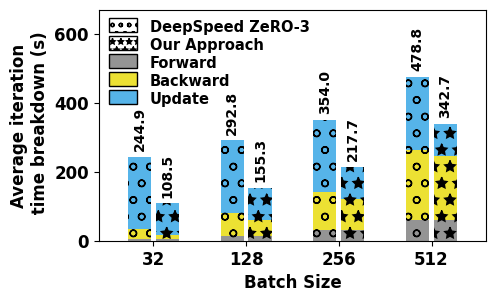

In [248]:
###############################################################
# Plot for different gradient accumulation degrees.
###############################################################
def plot_diff_grad_accum_iter_time(config, data):
    output_file = f"./plots/diff-grad-accum-iter-time"
    
    group_labels = list(data.keys())
    bar_labels = list(data[group_labels[0]].keys())
    bar_width = 0.3
    bar_gap = -0.05
    xrange = np.arange(len(group_labels))

    fig, ax = plt.subplots(figsize=(5, 3))
#     ax2 = ax.twinx()
    start_offset = -0.5
    offset = start_offset
    iter_time = {}
    fwd_time = {}
    bwd_time = {}
    step_time = {}
    
    # Add the legend for hatches first
    for i, blabel in enumerate(bar_labels):
        label = approach_code[blabel]
        ax.bar(xrange, np.zeros(len(xrange)), label=label, hatch=hatches[i], color='white')
    
    # Plot the bars
    for i, blabel in enumerate(bar_labels):
        try:
            iter_time[blabel] = [get_avg(data[glabel][blabel]['iter_time']) for glabel in group_labels]
            fwd_time[blabel] = [get_avg(data[glabel][blabel]['fwd'])/1e3 for glabel in group_labels]
            bwd_time[blabel] = [get_avg(data[glabel][blabel]['bwd'])/1e3 for glabel in group_labels]
            step_time[blabel] = [get_avg(data[glabel][blabel]['step'])/1e3 for glabel in group_labels]
        
            bottom = np.zeros(len(fwd_time[blabel]))
            ax.bar(xrange + offset * bar_width, fwd_time[blabel], bar_width+bar_gap, 
                   label=f'Forward', bottom=bottom, color=FWD_TIME_COLOR, hatch=hatches[i])
            bottom += fwd_time[blabel]
            ax.bar(xrange + offset * bar_width, bwd_time[blabel], bar_width+bar_gap, 
                   label=f'Backward', bottom=bottom, color=BWD_TIME_COLOR, hatch=hatches[i])
            bottom += bwd_time[blabel]
            ax.bar(xrange + offset * bar_width, step_time[blabel], bar_width+bar_gap, 
                   label=f'Update', bottom=bottom, color=STEP_TIME_COLOR, hatch=hatches[i])
            offset += 1
        except Exception as e:
            print(f"Error for bars: {blabel}: {bar_labels}, {e}")
    
    # Annotate the bars
    max_y = 0
    for j, glabel in enumerate(group_labels):
        try:
            offset = start_offset
            for i, blabel in enumerate(bar_labels):
                value = iter_time[blabel][j]
                max_y = max(max_y, value)
                ax.annotate(f'{value:.1f}', (xrange[j] + offset * bar_width, value + 15), 
                            ha='center', va='bottom', rotation=90, fontsize=10, fontweight='bold', zorder=100)
                offset += 1
        except Exception as e:
            print(f"Error for {glabel}: {group_labels}, {e}")
    
    ax.set_ylabel('Average iteration\n time breakdown (s)', fontsize=12, fontweight='bold')
    ax.set_xlabel('Batch Size', fontsize=12, fontweight='bold')
    ax.set_xticks(xrange)
    ax.set_xticklabels([f"{x*config['dp']*config['mbs']}" for i, x in enumerate(group_labels)])
    ax.set_ylim(top=max_y*1.4)
    # Plot the TFLOPs on secondary y-axis
#     tflops = {}
#     for i, blabel in enumerate(bar_labels):
#         tflops[blabel] = [get_avg(data[glabel][blabel]['TFLOPs']) for glabel in group_labels]
#         ax2.plot(xrange, tflops[blabel], color='blue', marker=markers[i], linestyle=linestyles[i],
#                  markersize=10, markerfacecolor=colors[i], markeredgecolor=colors[i], zorder=1)
#     ax2.tick_params(axis='y', color='blue', labelcolor='blue')
#     ax2.spines['right'].set_color('blue')
#     ax2.set_ylabel('TFLOPs (lines)', fontsize=12, fontweight='bold', color='blue')    
#     ax2.set_ylim(bottom=-20)

    handles, labels = ax.get_legend_handles_labels()
    labels = labels[:len(bar_labels)+3]
    legends = ax.legend(handles, labels, 
                        ncol=1, frameon=False, fontsize=10.5, loc='upper left',
             borderpad=0.2, labelspacing=0.2, columnspacing=0.5, ) 
    for i, handle in enumerate(legends.legendHandles):
        handle.set_edgecolor('black')
        handle.set_height(10)
        handle.set_width(20)
        if i < len(bar_labels):
            handle.set_hatch(handle.get_hatch()*2)
        else:
            handle.set_hatch(None)

    
    plt.savefig(f"{output_file}.eps", format='eps', bbox_inches='tight')
    plt.savefig(f"{output_file}.png", format='png', bbox_inches='tight')
    plt.show()


res = {}
model = 40
for ga in [1, 4, 8, 16]:
    config = copy.deepcopy(base_config)
    res[ga] = {}
    for k in [0, 9]:
        res[ga][k] = None
        config['basepath'] = f"./dl-io-outputs-test-dist-nvme-swap-diff-ga/act-output-{model}B"
        config['opt_gaps'] = k
        config['dp'] = 4
        config['mbs'] = 8
        config['tp'] = 1
        config['gbs'] = config['mbs']*config['dp']*ga
        # print("Got config as ", config)
        ans = None
        config['approach'] = approach_code[k]
        if k==0:
            config['cache'] = 0
            config['skip_grads'] = 0
            config['opt_ratio'] = 0
        elif k == 5:
            config['approach'] = approach_code[k]
            config['cache'] = 1
            config['skip_grads'] = 0
            config['opt_ratio'] = 2
            config['fs'] = "tmp-vast"
        elif k == 9:
            config['cache'] = 1
            config['skip_grads'] = 1
            config['opt_ratio'] = 3
            config['fs'] = "tmp-vast"
            config['compress'] = 1
            config['single_proc'] = 1
        else:
            print("Undefined K... Returning")
            import pdb; pdb.set_trace()
        ans = parse_log(MODELS[model], config)
        res[ga][k] = ans

plot_diff_grad_accum_iter_time(config, res)

Reading ./dl-io-outputs-test-dist-nvme-swap/act-output-40B/log-40B-tp1-dp4-l128-h5120-a40-sl2048-gbs4-mbs1-ratio1-subg100000000-pipelinerw1-opt_ratio0-cache0-skip_grads0-single_proc0-compress0-tmp.log
Reading ./dl-io-outputs-test-dist-nvme-swap/act-output-40B/log-40B-tp1-dp4-l128-h5120-a40-sl2048-gbs4-mbs1-ratio1-subg100000000-pipelinerw1-opt_ratio0-cache1-skip_grads0-single_proc0-compress0-tmp.log
Reading ./dl-io-outputs-test-dist-nvme-swap/act-output-40B/log-40B-tp1-dp4-l128-h5120-a40-sl2048-gbs4-mbs1-ratio1-subg100000000-pipelinerw1-opt_ratio0-cache1-skip_grads1-single_proc0-compress0-tmp.log
Reading ./dl-io-outputs-test-dist-nvme-swap/act-output-40B/log-40B-tp1-dp4-l128-h5120-a40-sl2048-gbs4-mbs1-ratio1-subg100000000-pipelinerw1-opt_ratio0-cache1-skip_grads1-single_proc1-compress0-tmp.log
Reading ./dl-io-outputs-test-dist-nvme-swap/act-output-70B/log-70B-tp1-dp4-l80-h8192-a64-sl2048-gbs4-mbs1-ratio1-subg100000000-pipelinerw1-opt_ratio0-cache0-skip_grads0-single_proc0-compress0-tmp.

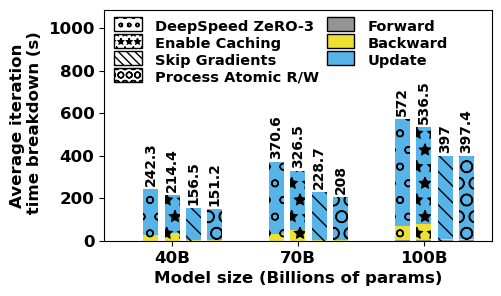

Reading ./dl-io-outputs-test-dist-nvme-swap/act-output-40B/log-40B-tp1-dp4-l128-h5120-a40-sl2048-gbs4-mbs1-ratio1-subg100000000-pipelinerw1-opt_ratio2-cache1-skip_grads0-single_proc0-compress0-tmp-vast.log
Reading ./dl-io-outputs-test-dist-nvme-swap/act-output-40B/log-40B-tp1-dp4-l128-h5120-a40-sl2048-gbs4-mbs1-ratio1-subg100000000-pipelinerw1-opt_ratio2-cache1-skip_grads1-single_proc0-compress0-tmp-vast.log
Reading ./dl-io-outputs-test-dist-nvme-swap/act-output-40B/log-40B-tp1-dp4-l128-h5120-a40-sl2048-gbs4-mbs1-ratio1-subg100000000-pipelinerw1-opt_ratio3-cache1-skip_grads1-single_proc1-compress1-tmp-vast.log
Reading ./dl-io-outputs-test-dist-nvme-swap/act-output-70B/log-70B-tp1-dp4-l80-h8192-a64-sl2048-gbs4-mbs1-ratio1-subg100000000-pipelinerw1-opt_ratio2-cache1-skip_grads0-single_proc0-compress0-tmp-vast.log
Reading ./dl-io-outputs-test-dist-nvme-swap/act-output-70B/log-70B-tp1-dp4-l80-h8192-a64-sl2048-gbs4-mbs1-ratio1-subg100000000-pipelinerw1-opt_ratio2-cache1-skip_grads1-single_p

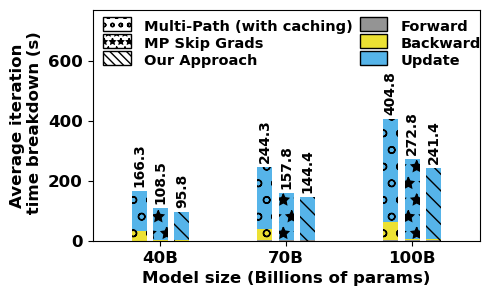

In [60]:
###############################################################
# Plot for ablation to characterize different optimization
###############################################################
def plot_diff_approach_ablations(config, data, disk):
    output_file = f"./plots/diff-approaches-ablation-{disk}"
    
    group_labels = list(data.keys())
    bar_labels = list(data[group_labels[0]].keys())
    bar_width = 0.17
    bar_gap = -0.05
    xrange = np.arange(len(group_labels))

    fig, ax = plt.subplots(figsize=(5, 3))
#     ax2 = ax.twinx()
    start_offset = -1
    offset = start_offset
    iter_time = {}
    fwd_time = {}
    bwd_time = {}
    step_time = {}
    
    # Add the legend for hatches first
    for i, blabel in enumerate(bar_labels):
        label = approach_code[blabel]
        ax.bar(xrange, np.zeros(len(xrange)), label=label, hatch=hatches[i], color='white')
    
    # Plot the bars
    for i, blabel in enumerate(bar_labels):
        try:
            iter_time[blabel] = [get_avg(data[glabel][blabel]['iter_time']) for glabel in group_labels]
            fwd_time[blabel] = [get_avg(data[glabel][blabel]['fwd'])/1e3 for glabel in group_labels]
            bwd_time[blabel] = [get_avg(data[glabel][blabel]['bwd'])/1e3 for glabel in group_labels]
            step_time[blabel] = [get_avg(data[glabel][blabel]['step'])/1e3 for glabel in group_labels]
        except Exception as e:
            print(f"Error for {blabel}")
        
        bottom = np.zeros(len(fwd_time[blabel]))
        ax.bar(xrange + offset * bar_width, fwd_time[blabel], bar_width+bar_gap, 
               label=f'Forward', bottom=bottom, color=FWD_TIME_COLOR, hatch=hatches[i])
        bottom += fwd_time[blabel]
        ax.bar(xrange + offset * bar_width, bwd_time[blabel], bar_width+bar_gap, 
               label=f'Backward', bottom=bottom, color=BWD_TIME_COLOR, hatch=hatches[i])
        bottom += bwd_time[blabel]
        ax.bar(xrange + offset * bar_width, step_time[blabel], bar_width+bar_gap, 
               label=f'Update', bottom=bottom, color=STEP_TIME_COLOR, hatch=hatches[i])
        offset += 1
    
    # Annotate the bars
    max_y = 0
    for j, glabel in enumerate(group_labels):
        offset = start_offset
        for i, blabel in enumerate(bar_labels):
            value = iter_time[blabel][j]
            max_y = max(max_y, value)
            value = round(value, 1)
            if int(value) == value:
                value = int(value)
            ax.annotate(f'{value}', (xrange[j] + offset * bar_width, value + 15), 
                        ha='center', va='bottom', rotation=90, fontsize=10, fontweight='bold', zorder=100)
            offset += 1
    
    ax.set_ylabel('Average iteration\n time breakdown (s)', fontsize=12, fontweight='bold')
    ax.set_xlabel('Model size (Billions of params)', fontsize=12, fontweight='bold')
    ax.set_xticks(xrange)
    ax.set_xticklabels([f"{x}B" for i, x in enumerate(group_labels)])
    ax.set_ylim(top=max_y*1.9)
    # Plot the TFLOPs on secondary y-axis
#     tflops = {}
#     for i, blabel in enumerate(bar_labels):
#         tflops[blabel] = [get_avg(data[glabel][blabel]['TFLOPs']) for glabel in group_labels]
#         ax2.plot(xrange, tflops[blabel], color='blue', marker=markers[i], linestyle=linestyles[i],
#                  markersize=10, markerfacecolor=colors[i], markeredgecolor=colors[i], zorder=1)
#     ax2.tick_params(axis='y', color='blue', labelcolor='blue')
#     ax2.spines['right'].set_color('blue')
#     ax2.set_ylabel('TFLOPs (lines)', fontsize=12, fontweight='bold', color='blue')    
#     ax2.set_ylim(bottom=-20)

    handles, labels = ax.get_legend_handles_labels()
    labels = labels[:len(bar_labels)+3]
    legends = ax.legend(handles, labels, 
                        ncol=2, frameon=False, fontsize=10.5, loc='upper left',
             borderpad=0.2, labelspacing=0.2, columnspacing=0.5, ) 
    for i, handle in enumerate(legends.get_patches()):
        handle.set_edgecolor('black')
        handle.set_height(10)
        handle.set_width(20)
        if i < len(bar_labels):
            handle.set_hatch(handle.get_hatch()*2)
        else:
            handle.set_hatch(None)

    
    plt.savefig(f"{output_file}.eps", format='eps', bbox_inches='tight')
    plt.savefig(f"{output_file}.png", format='png', bbox_inches='tight')
    plt.show()


res = {}
for model in [40, 70, 100]:
    config = copy.deepcopy(base_config)
    res[model] = {}
    for k in [0, 1, 2, 3]:
        res[model][k] = None
        config['basepath'] = f"./dl-io-outputs-test-dist-nvme-swap/act-output-{model}B"
        config['opt_gaps'] = k
        config['dp'] = 4
        config['mbs'] = 1
        config['tp'] = 1
        config['gbs'] = config['mbs']*config['dp']
        # print("Got config as ", config)
        ans = None
        config['approach'] = approach_code[k]
        if k==0:
            config['cache'] = 0
            config['skip_grads'] = 0
        elif k == 1:
            config['cache'] = 1
            config['skip_grads'] = 0
        elif k == 2:
            config['cache'] = 1
            config['skip_grads'] = 1
        elif k == 3:
            config['cache'] = 1
            config['skip_grads'] = 1
            config['single_proc'] = 1
        elif k == 4:
            config['cache'] = 1
            config['skip_grads'] = 1
            config['single_proc'] = 1
            config['compress'] = 1
        else:
            print("Undefined K... Returning")
            import pdb; pdb.set_trace()
        ans = parse_log(MODELS[model], config)
        res[model][k] = ans

plot_diff_approach_ablations(config, res, "tmp")

res = {}
for model in [40, 70, 100]:
    config = copy.deepcopy(base_config)
    res[model] = {}
    for k in [5, 6, 9]:
        res[model][k] = None
        config['basepath'] = f"./dl-io-outputs-test-dist-nvme-swap/act-output-{model}B"
        config['opt_gaps'] = k
        config['dp'] = 4
        config['mbs'] = 1
        config['tp'] = 1
        config['gbs'] = config['mbs']*config['dp']
        # print("Got config as ", config)
        ans = None
        config['approach'] = approach_code[k]
        config['fs'] = "tmp-vast"
        config['opt_ratio'] = 2
        if k==5:
            config['cache'] = 1
            config['skip_grads'] = 0
        elif k == 6:
            config['cache'] = 1
            config['skip_grads'] = 1
        elif k == 7:
            config['cache'] = 1
            config['skip_grads'] = 1
            config['single_proc'] = 1
        elif k == 8:
            config['cache'] = 1
            config['skip_grads'] = 1
            config['single_proc'] = 1
            config['compress'] = 1
        elif k == 9:
            config['opt_ratio'] = 3
            config['cache'] = 1
            config['skip_grads'] = 1
            config['single_proc'] = 1
            config['compress'] = 1
        else:
            print("Undefined K... Returning")
            import pdb; pdb.set_trace()
        ans = parse_log(MODELS[model], config)
        res[model][k] = ans

plot_diff_approach_ablations(config, res, "tmp-vast")

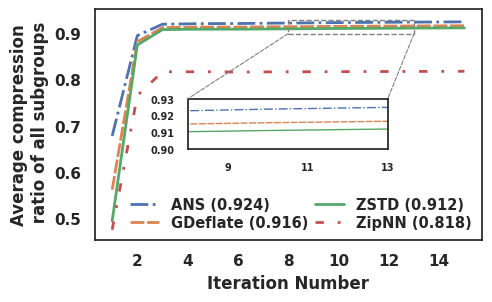

In [201]:
###############################################################
# Plot for different compression ratios trend
###############################################################
def parse_and_precompute(file_path):
    # Load JSON data
    with open(file_path, "r") as f:
        data = json.load(f)

    # Prepare data for aggregation
    plot_data = []
    for subkey in range(15):  # Assuming 12 subkeys (0-11)
        compressor_cr = {compressor: [] for compressor in data[list(data.keys())[0]]["0"][0].keys()}
        compressor_ct = {compressor: [] for compressor in data[list(data.keys())[0]]["0"][0].keys()}
        compressor_dt = {compressor: [] for compressor in data[list(data.keys())[0]]["0"][0].keys()}
        compressor_cdt = {compressor: [] for compressor in data[list(data.keys())[0]]["0"][0].keys()}

        # Aggregate CRs across all top-level keys
        for top_key, subkeys in data.items():
            subgroups = subkeys[str(subkey)]
            for subgroup in subgroups:
                for compressor, metrics in subgroup.items():
                    compressor_cr[compressor].append(metrics["cr"])
                    compressor_ct[compressor].append((metrics["bytes"]/(1024**3))/metrics["ct"])
                    compressor_dt[compressor].append((metrics["bytes"]/(1024**3))/metrics["dt"])
                    compressor_cdt[compressor].append((2*metrics["bytes"]/(1024**3))/(metrics["dt"]+metrics["ct"]))

        # Calculate mean and variance for each compressor
        for compressor, cr_values in compressor_cr.items():
            mean_cr = np.mean(cr_values)
            var_cr = np.var(cr_values)
            mean_ct = np.mean(compressor_ct[compressor])
            mean_dt = np.mean(compressor_dt[compressor])
            mean_cdt = np.mean(compressor_cdt[compressor])
            plot_data.append({
                "Subkey": subkey+1,
                "Compressor": compressor,
                "Mean CR": mean_cr,
                "Mean CT": mean_ct,
                "Mean DT": mean_dt,
                "Mean CDT": mean_cdt,
                "Variance CR": var_cr
            })

    # Convert to DataFrame
    return pd.DataFrame(plot_data)


def plot_compression_ratios(data):
    output_file = f"./plots/diff-comp-ratios"
    sns.set(style="white")
    fig, ax = plt.subplots(figsize=(5, 3))

    # Line styles for each compressor
    line_styles = {
        "LZ4": "dotted",
        "Snappy": "--",
        "Bitcomp": ":",
        "ANS": "-.",
        "ZSTD": "solid",  # Custom dash-dot pattern
        "GDeflate": (0, (5, 1)),  # Custom dashed pattern
        "ZipNN": (0, (3, 5, 1, 5))
    }

    # Unique compressors
    compressors = data["Compressor"].unique()
    mean_vals = {}
    for compressor in sorted(compressors):
        # Filter data for each compressor
        compressor_data = data[data["Compressor"] == compressor]
        mean_vals[compressor] = compressor_data["Mean CR"][8:].mean()
        ax.plot(
            compressor_data["Subkey"],
            compressor_data["Mean CR"],
            label=compressor,
            linestyle=line_styles[compressor],
            linewidth=2
        )
    
    ax.set_xlabel("Iteration Number", fontsize=12, fontweight='bold')
    ax.set_ylabel("Average compression\n ratio of all subgroups", fontsize=12, fontweight='bold')
    
    handles, labels = ax.get_legend_handles_labels()
    for i, x in enumerate(labels):
        labels[i] = f"{x} ({round(mean_vals[x], 3)})"
        
    legends = ax.legend(handles, labels, ncol=2, frameon=False, fontsize=10.5,
             borderpad=0.2, labelspacing=0.2, columnspacing=0.5)
    
    # Add zoomed-in inset
    inset = inset_axes(ax, width=2, height=0.5, loc="lower left", bbox_to_anchor=(4, 0.65),
                       bbox_transform=ax.transData, borderpad=0)
    inset.set_xlim(8, 13)
    inset.set_ylim(0.9, 0.93)
    inset.tick_params(axis='both', which='major', labelsize=7)

    # Plot data on inset
    for compressor in sorted(compressors):
        compressor_data = data[data["Compressor"] == compressor]
        inset.plot(
            compressor_data["Subkey"],
            compressor_data["Mean CR"],
            linestyle=line_styles[compressor],
            linewidth=1
        )

    inset.set_xticks([9, 11, 13])
    inset.set_yticks([0.9, 0.91, 0.92, 0.93])

    # Draw zoom connection lines
    rect = [8, 0.9, 5, 0.03]  # [x0, y0, width, height] of zoomed-in region
    x0, x1 = rect[0], rect[0] + rect[2]
    y0, y1 = rect[1], rect[1]
    inset_rect = inset.get_position()

    # Draw rectangle in main plot to indicate zoom area
    ax.add_patch(plt.Rectangle((x0, y0), rect[2], rect[3], 
                                edgecolor="gray", linewidth=1, linestyle="--", fill=False))

    # Draw connection patches from corners of zoom area to corners of inset
    con_tl = ConnectionPatch(
        xyA=(x0, y1), coordsA=ax.transData,  # Top-left of zoom region
        xyB=(0, 1), coordsB=inset.transAxes,  # Top-left of inset
        axesA=ax, axesB=inset, color="gray", linestyle="--", linewidth=0.8
    )
    con_tr = ConnectionPatch(
        xyA=(x1, y1), coordsA=ax.transData,  # Top-right of zoom region
        xyB=(1, 1), coordsB=inset.transAxes,  # Top-right of inset
        axesA=ax, axesB=inset, color="gray", linestyle="--", linewidth=0.8
    )
    fig.add_artist(con_tl)
    fig.add_artist(con_tr)

    plt.savefig(f"{output_file}.eps", format='eps', bbox_inches='tight')
    plt.savefig(f"{output_file}.png", format='png', bbox_inches='tight')
    plt.show()

res = parse_and_precompute("comp-ratios.json")
plot_compression_ratios(res)


{'ZIPNN\nSlow': {'compression': {'average_ratio': 0.8530893698334694, 'average_throughput': 0.5426954316517628}, 'decompression': {'average_throughput': 0.9883101885369036}, 'total_throughput': 0.7655028100943332}, 'ZSTD\nFast': {'compression': {'average_ratio': 0.9282856350764632, 'average_throughput': 1.5163253200423898}, 'decompression': {'average_throughput': 0.8860838621711732}, 'total_throughput': 1.2012045911067815}, 'ZSTD\nSlow': {'compression': {'average_ratio': 0.9275468243286014, 'average_throughput': 0.004753311517150366}, 'decompression': {'average_throughput': 0.7880531354526674}, 'total_throughput': 0.3964032234849089}, 'GZIP\nSlow': {'compression': {'average_ratio': 0.9308092901483178, 'average_throughput': 0.029060369316314172}, 'decompression': {'average_throughput': 0.1455957405318717}, 'total_throughput': 0.08732805492409293}, 'BLOSC\nSlow': {'compression': {'average_ratio': 0.9544829102233052, 'average_throughput': 1.9087981722218745}, 'decompression': {'average_th

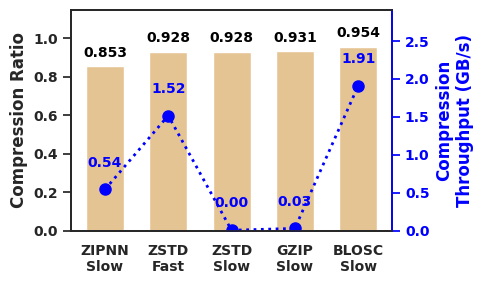

In [203]:
###############################################################
# Plot for different compression ratios and speeds
###############################################################
def plot_compression_results(data, output_file):
    output_file = f"./plots/{output_file}"
    compressors = list(data.keys())
    compression_ratios = [metrics["compression"]["average_ratio"] for metrics in data.values()]
    compression_throughputs = [metrics["compression"]["average_throughput"] for metrics in data.values()]

    x = np.arange(len(compressors))  # x positions for bars

    fig, ax1 = plt.subplots(figsize=(5, 3))

    # Bar chart for compression ratios
    bar_color = sns.color_palette("Set2")[6]
    bars = ax1.bar(x, compression_ratios, color=bar_color, width=0.6, label="Compression Ratio")
    ax1.set_ylabel("Compression Ratio", fontsize=12, fontweight="bold")
    ax1.set_xticks(x)
    ax1.set_xticklabels(compressors, rotation=0, ha='center', fontsize=10)
    ax1.tick_params(axis='y', labelsize=10)
    ax1.set_ylim(0, max(compression_ratios)*1.2)

    # Annotate compression ratios on top of the bars
    for bar, ratio in zip(bars, compression_ratios):
        ax1.text(
            bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.05,
            f"{ratio:.3f}", ha="center", fontsize=10, color="black"
        )

    # Line chart for compression throughputs
    ax2 = ax1.twinx()
    ax2.plot(
        x, compression_throughputs, color="blue", linestyle="dotted", linewidth=2, marker="o",
        markersize=8, label="Compression Throughput"
    )
    ax2.set_ylabel("Compression\nThroughput (GB/s)", fontsize=12, fontweight="bold", color="blue")
    ax2.tick_params(axis='y', labelsize=10, colors="blue")
    ax2.spines["right"].set_color("blue")
    ax2.yaxis.label.set_color("blue")
    ax2.set_ylim(0, max(compression_throughputs) + 1)

    for i, throughput in enumerate(compression_throughputs):
        ax2.text(
            x[i], throughput + 0.3, f"{throughput:.2f}", ha="center",
            fontsize=10, color="blue"
        )

    fig.tight_layout()
    plt.savefig(f"{output_file}.eps", format='eps', bbox_inches='tight')
    plt.savefig(f"{output_file}.png", format='png', bbox_inches='tight')
    plt.show()


def plot_cpu_comp_cr():
    with open("cpu-compressors-cr-thru.log", "r") as f:
        data = json.load(f)
    res = {}
    for k, v in data.items():
        if "zipnn-0" in k or v["compression"]["average_ratio"] > 0.999:
            continue
        [name, level] = k.split("-")
        level_name = "Fast" if int(level) == 0 else "Slow"
        res[f"{name.upper()}\n{level_name}"] = v
    print(res)
    plot_compression_results(res, "cpu-comp-ratio-thru")
    
def plot_gpu_comp_cr():
    with open("gpu-compressors-cr-thru.log", "r") as f:
        data = json.load(f)
    res = {}
    for k, v in data.items():
        if (k not in ["LZ4", "Cascaded"]) and (v["compression"]["average_ratio"] > 0.999 or k == "Deflate"):
            continue
        if "Zstd" in k: 
            k = k.upper()
        res[k] = v
    print(res)
    plot_compression_results(res, "gpu-comp-ratio-thru")
plot_cpu_comp_cr()


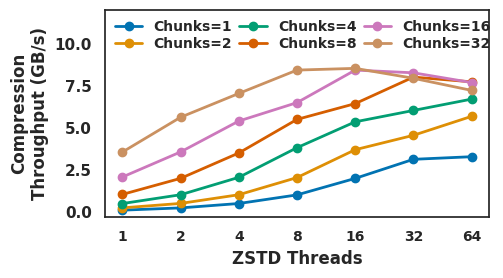

In [250]:
###############################################################
# Plot for OMP and ZSTD threads
###############################################################
def plot_omp_zstd_comp_thru():
    data = """OMP_threads, ZSTD_threads, Compression_Ratio, Compression_Throughput(GB/s),Total_Execution_Time(s)
    1, 1, 0.928278, 0.135744, 31.6403
    1, 2, 0.928278, 0.269502, 15.9367
    1, 4, 0.928278, 0.530216, 8.10041
    1, 8, 0.928278, 1.04029, 4.12861
    1, 16, 0.928278, 2.01854, 2.12776
    1, 32, 0.928278, 3.14961, 1.36365
    1, 64, 0.928278, 3.30418, 1.29986
    2, 1, 0.928278, 0.271295, 15.8314
    2, 2, 0.928278, 0.535335, 8.02295
    2, 4, 0.928278, 1.04987, 4.09096
    2, 8, 0.928278, 2.0673, 2.07757
    2, 16, 0.928278, 3.71901, 1.15487
    2, 32, 0.928278, 4.5722, 0.939367
    2, 64, 0.928278, 5.69696, 0.753906
    4, 1, 0.928279, 0.527367, 8.14418
    4, 2, 0.928279, 1.04988, 4.09091
    4, 4, 0.928279, 2.08072, 2.06418
    4, 8, 0.928279, 3.83794, 1.11908
    4, 16, 0.928279, 5.3717, 0.799555
    4, 32, 0.928279, 6.04547, 0.710444
    4, 64, 0.928279, 6.71785, 0.639336
    8, 1, 0.928278, 1.06966, 4.01526
    8, 2, 0.928278, 2.02075, 2.12543
    8, 4, 0.928278, 3.52456, 1.21858
    8, 8, 0.928278, 5.51507, 0.778769
    8, 16, 0.928278, 6.45097, 0.665786
    8, 32, 0.928278, 8.02256, 0.535362
    8, 64, 0.928278, 7.74168, 0.554785
    16, 1, 0.928278, 2.10006, 2.04517
    16, 2, 0.928278, 3.58682, 1.19743
    16, 4, 0.928278, 5.4181, 0.792707
    16, 8, 0.928278, 6.50972, 0.659778
    16, 16, 0.928278, 8.43702, 0.509062
    16, 32, 0.928278, 8.27741, 0.518878
    16, 64, 0.928278, 7.70031, 0.557766
    32, 1, 0.92828, 3.5797, 1.19981
    32, 2, 0.92828, 5.64304, 0.761109
    32, 4, 0.92828, 7.05448, 0.608828
    32, 8, 0.92828, 8.43833, 0.508983
    32, 16, 0.92828, 8.54121, 0.502852
    32, 32, 0.92828, 7.95258, 0.540072
    32, 64, 0.92828, 7.2343, 0.593695
    64, 1, 0.928282, 5.67088, 0.757372
    64, 2, 0.928282, 6.91687, 0.620941
    64, 4, 0.928282, 8.88283, 0.483513
    64, 8, 0.928282, 8.18707, 0.524603
    64, 16, 0.928282, 7.83806, 0.547963
    64, 32, 0.928282, 7.23912, 0.593299
    64, 64, 0.928282, 6.25217, 0.686956
    """
    output_file="./plots/omp_zstd_comp_thru"

    df = pd.read_csv(io.StringIO(data))
    df.columns = df.columns.str.strip()
    df["ZSTD_threads"] = df["ZSTD_threads"].astype(str)
    df["OMP_threads"] = df["OMP_threads"].astype(int)
    df = df[df["OMP_threads"] != 64]
    

    fig, ax = plt.subplots(figsize=(5, 3))

    # Unique OMP_threads
    omp_threads = sorted(df['OMP_threads'].unique())

    # Plot for each OMP_threads
    for omp in omp_threads:
        subset = df[df['OMP_threads'] == omp]
        ax.plot(
            subset['ZSTD_threads'],
            subset['Compression_Throughput(GB/s)'],
            label=f"Chunks={omp}",
            marker='o',
            linewidth=2
        )

    
    ax.set_ylim(top=12)
    ax.set_xlabel("ZSTD Threads", fontsize=12, fontweight='bold')
    ax.set_ylabel("Compression\nThroughput (GB/s)", fontsize=12, fontweight='bold')
    # Customize x-axis to only show ticks for actual ZSTD_threads
    plt.xticks(sorted(df["ZSTD_threads"].unique()), fontsize=10)
    plt.legend(ncol=3, frameon=False, fontsize=10, loc='upper left',
             borderpad=0.2, labelspacing=0.2, columnspacing=0.5)
    plt.grid(visible=False)

    # Show the plot
    plt.tight_layout()
    plt.savefig(f"{output_file}.eps", format='eps', bbox_inches='tight')
    plt.savefig(f"{output_file}.png", format='png', bbox_inches='tight')
    plt.show()
plot_omp_zstd_comp_thru()

Reading ./dl-io-outputs-test-dist-nvme-swap/act-output-40B/log-40B-tp1-dp4-l128-h5120-a40-sl2048-gbs4-mbs1-ratio1-subg100000000-pipelinerw1-opt_ratio0-cache0-skip_grads0-single_proc0-tmp.log
Reading ./dl-io-outputs-test-dist-nvme-swap/act-output-40B/log-40B-tp1-dp4-l128-h5120-a40-sl2048-gbs4-mbs1-ratio1-subg100000000-pipelinerw1-opt_ratio0-cache1-skip_grads0-single_proc0-tmp.log
Reading ./dl-io-outputs-test-dist-nvme-swap/act-output-40B/log-40B-tp1-dp4-l128-h5120-a40-sl2048-gbs4-mbs1-ratio1-subg100000000-pipelinerw1-opt_ratio0-cache1-skip_grads1-single_proc0-tmp.log
Reading ./dl-io-outputs-test-dist-nvme-swap/act-output-40B/log-40B-tp1-dp4-l128-h5120-a40-sl2048-gbs4-mbs1-ratio1-subg100000000-pipelinerw1-opt_ratio3-cache1-skip_grads1-single_proc0-tmp-vast.log
Reading ./dl-io-outputs-test-dist-nvme-swap/act-output-52B/log-52B-tp1-dp4-l64-h8192-a64-sl2048-gbs4-mbs1-ratio1-subg100000000-pipelinerw1-opt_ratio0-cache0-skip_grads0-single_proc0-tmp.log
Reading ./dl-io-outputs-test-dist-nvme-sw

/tmp/ipykernel_3250813/1674547849.py:65: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  for i, handle in enumerate(legends.legendHandles):


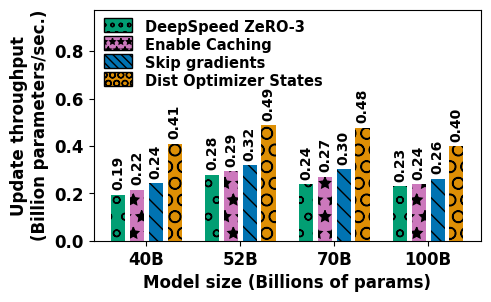

In [57]:
###############################################################
# Plot for different model sizes the update throughput.
###############################################################
def plot_diff_models_update_thru(config, data):
    output_file = f"./plots/diff-models-update-thru"
    
    group_labels = list(data.keys())
    bar_labels = list(data[group_labels[0]].keys())
    bar_width = 0.2
    bar_gap = -0.05
    xrange = np.arange(len(group_labels))
    
    fig, ax = plt.subplots(figsize=(5, 3))
    # ax2 = ax.twinx()
    offset_start = -1.5
    offset = offset_start
    update_thru = {}
    # Plot the bars
    for i, blabel in enumerate(bar_labels):
        update_thru[blabel] = [0]*len(group_labels)
        for j, glabel in enumerate(group_labels):
            if data[glabel][blabel]['step'] is not None and len(data[glabel][blabel]['step'])>0:
                update_thru[blabel][j] = (glabel)/(get_avg(data[glabel][blabel]['step'])/1e3)
                # print(f"For {blabel}, {glabel}, time is {data[glabel][blabel]['step']}")
                # update_thru[blabel][j] = get_avg(data[glabel][blabel]['step'])/1e3
        label = "Default" if blabel == 0 else (str(100//blabel) + "%" + f"[k={blabel}]")
        ax.bar(xrange + offset * bar_width, update_thru[blabel], bar_width+bar_gap, 
               label=f'{label}', color=colors[i], hatch=hatches[i])
        offset += 1
    
    max_y = 0
    # Annotate the bars
    for j, glabel in enumerate(group_labels):
        offset = offset_start
        for i, blabel in enumerate(bar_labels):
            value = update_thru[blabel][j]
            max_y = max(max_y, value)
            print_val = f'{value:.2f}'
            print_color = 'black'
            ax.annotate(print_val, (xrange[j] + offset * bar_width, value + 0.02), 
                        ha='center', va='bottom', rotation=90, 
                        fontsize=10, fontweight='bold', zorder=100, color=print_color)
            offset += 1
    
    ax.set_ylabel('Update throughput\n(Billion parameters/sec.)', fontsize=12, fontweight='bold')
    ax.set_xlabel('Model size (Billions of params)', fontsize=12, fontweight='bold')
    ax.set_xticks(xrange)
    ax.set_xticklabels([f"{x}B" for i, x in enumerate(group_labels)])
    ax.set_ylim(top=max_y*2)
    # Plot the TFLOPs on secondary y-axis
    # tflops = {}
    # for i, blabel in enumerate(bar_labels):
    #     tflops[blabel] = [get_avg(data[glabel][blabel]['TFLOPs']) for glabel in group_labels]
    #     ax2.plot(xrange, tflops[blabel], color='blue', marker=markers[i], linestyle=linestyles[i],
    #              markersize=10, markerfacecolor=colors[i], markeredgecolor=colors[i], zorder=1)
    # ax2.tick_params(axis='y', color='blue', labelcolor='blue')
    # ax2.spines['right'].set_color('blue')
    # ax2.set_ylabel('TFLOPs (lines)', fontsize=12, fontweight='bold', color='blue')    
    # ax2.set_ylim(bottom=-20)

    handles, labels = ax.get_legend_handles_labels()
    legends = ax.legend(handles, list(approach_code.values()), 
                        ncol=1, frameon=False, fontsize=10.5, loc='upper left',
             borderpad=0.2, labelspacing=0.2, columnspacing=0.5, ) 
    for i, handle in enumerate(legends.legendHandles):
        handle.set_edgecolor('black')
        handle.set_height(10)
        handle.set_width(20)
        if i < len(bar_labels):
            handle.set_hatch(handle.get_hatch()*2)
        else:
            handle.set_hatch(None)

    
    plt.savefig(f"{output_file}.eps", format='eps', bbox_inches='tight')
    plt.savefig(f"{output_file}.png", format='png', bbox_inches='tight')
    plt.show()


res = {}
for model in [40, 52, 70, 100]:
    config = copy.deepcopy(base_config)
    res[model] = {}
    for k in [0, 1, 2, 3]:
        res[model][k] = None
        config['basepath'] = f"./dl-io-outputs-test-dist-nvme-swap/act-output-{model}B"
        config['opt_gaps'] = k
        config['dp'] = 4
        config['mbs'] = 1
        config['tp'] = 1
        config['gbs'] = config['mbs']*config['dp']
        # print("Got config as ", config)
        ans = None
        if k==0:
            config['approach'] = DEFAULT_DEEPSPEED
            config['cache'] = 0
            config['skip_grads'] = 0
            config['opt_ratio'] = 0
        elif k == 1:
            config['approach'] = ENABLE_CACHING
            config['cache'] = 1
            config['skip_grads'] = 0
            config['opt_ratio'] = 0
        elif k == 2:
            config['approach'] = SKIP_GRADS
            config['cache'] = 1
            config['skip_grads'] = 1
            config['opt_ratio'] = 0
        elif k == 3:
            config['approach'] = FULLY_OPTIMIZED
            config['cache'] = 1
            config['skip_grads'] = 1
            config['opt_ratio'] = 3
            config['fs'] = "tmp-vast"
        else:
            print("Undefined K... Returning")
            import pdb; pdb.set_trace()
        ans = parse_log(MODELS[model], config)
        res[model][k] = ans

plot_diff_models_update_thru(config, res)

Reading ./dl-io-outputs-test-dist-nvme-swap/act-output-40B/log-40B-tp1-dp4-l128-h5120-a40-sl2048-gbs4-mbs1-ratio1-subg100000000-pipelinerw1-opt_ratio0-cache0-skip_grads0-single_proc0-tmp.log
Reading ./dl-io-outputs-test-dist-nvme-swap/act-output-40B/log-40B-tp1-dp4-l128-h5120-a40-sl2048-gbs4-mbs1-ratio1-subg100000000-pipelinerw1-opt_ratio0-cache1-skip_grads0-single_proc0-tmp.log
Reading ./dl-io-outputs-test-dist-nvme-swap/act-output-40B/log-40B-tp1-dp4-l128-h5120-a40-sl2048-gbs4-mbs1-ratio1-subg100000000-pipelinerw1-opt_ratio0-cache1-skip_grads1-single_proc0-tmp.log
Reading ./dl-io-outputs-test-dist-nvme-swap/act-output-40B/log-40B-tp1-dp4-l128-h5120-a40-sl2048-gbs4-mbs1-ratio1-subg100000000-pipelinerw1-opt_ratio3-cache1-skip_grads1-single_proc0-tmp-vast.log
Reading ./dl-io-outputs-test-dist-nvme-swap/act-output-52B/log-52B-tp1-dp4-l64-h8192-a64-sl2048-gbs4-mbs1-ratio1-subg100000000-pipelinerw1-opt_ratio0-cache0-skip_grads0-single_proc0-tmp.log
Reading ./dl-io-outputs-test-dist-nvme-sw

/tmp/ipykernel_3250813/1258047613.py:63: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  for i, handle in enumerate(legends.legendHandles):


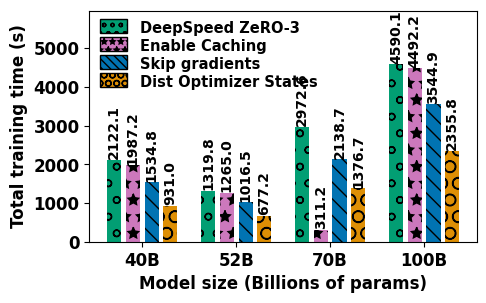

In [60]:
###############################################################
# Plot for end-to-end runtime of different model sizes.
###############################################################
def plot_diff_model_end_to_end(config, data):
    output_file = f"./plots/diff-models-end-to-end"
    
    group_labels = list(data.keys())
    bar_labels = list(data[group_labels[0]].keys())
    bar_width = 0.2
    bar_gap = -0.05
    xrange = np.arange(len(group_labels))
    
    fig, ax = plt.subplots(figsize=(5, 3))
    offset_start = -1.5
    offset = offset_start
    total_time = {}
    # Plot the bars
    for i, blabel in enumerate(bar_labels):
        total_time[blabel] = [0]*len(group_labels)
        for j, glabel in enumerate(group_labels):
            total_time[blabel][j] = sum(data[glabel][blabel]['iter_time'])
        label = "Default" if blabel == 0 else (str(100//blabel) + "%" + f"[k={blabel}]")
        ax.bar(xrange + offset * bar_width, total_time[blabel], bar_width+bar_gap, 
               label=f'{label}', color=colors[i], hatch=hatches[i])
        offset += 1
    
    max_y = 0
    # Annotate the bars
    for j, glabel in enumerate(group_labels):
        offset = offset_start
        for i, blabel in enumerate(bar_labels):
            value = total_time[blabel][j]
            max_y = max(max_y, value)
            print_val = f'{value:.1f}'
            print_color = 'black'
            ax.annotate(print_val, (xrange[j] + offset * bar_width, value + 15), 
                        ha='center', va='bottom', rotation=90, 
                        fontsize=10, fontweight='bold', zorder=100, color=print_color)
            offset += 1
    
    # ax.set_xlabel('Gradient acc. degree [Global batch size]', fontsize=12, fontweight='bold')
    ax.set_ylabel('Total training time (s)', fontsize=12, fontweight='bold')
    ax.set_xlabel('Model size (Billions of params)', fontsize=12, fontweight='bold')
    ax.set_xticks(xrange)
    ax.set_ylim(top=max_y*1.3)
    ax.set_xticklabels([f"{x}B" for i, x in enumerate(group_labels)])
    # Plot the TFLOPs on secondary y-axis
    # ax2 = ax.twinx()
    # tflops = {}
    # for i, blabel in enumerate(bar_labels):
    #     tflops[blabel] = [get_avg(data[glabel][blabel]['TFLOPs']) for glabel in group_labels]
    #     ax2.plot(xrange, tflops[blabel], color='blue', marker=markers[i], linestyle=linestyles[i],
    #              markersize=10, markerfacecolor=colors[i], markeredgecolor=colors[i], zorder=1)
    # ax2.tick_params(axis='y', color='blue', labelcolor='blue')
    # ax2.spines['right'].set_color('blue')
    # ax2.set_ylabel('TFLOPs (lines)', fontsize=12, fontweight='bold', color='blue')    
    # ax2.set_ylim(bottom=-20)

    handles, labels = ax.get_legend_handles_labels()
    legends = ax.legend(handles, list(approach_code.values()), 
                        ncol=1, frameon=False, fontsize=10.5, loc='upper left',
             borderpad=0.2, labelspacing=0.2, columnspacing=0.5, ) 
    for i, handle in enumerate(legends.legendHandles):
        handle.set_edgecolor('black')
        handle.set_height(10)
        handle.set_width(20)
        if i < len(bar_labels):
            handle.set_hatch(handle.get_hatch()*2)
        else:
            handle.set_hatch(None)

    
    plt.savefig(f"{output_file}.eps", format='eps', bbox_inches='tight')
    plt.savefig(f"{output_file}.png", format='png', bbox_inches='tight')
    plt.show()


    
res = {}
for model in [40, 52, 70, 100]:
    config = copy.deepcopy(base_config)
    res[model] = {}
    for k in [0, 1, 2, 3]:
        res[model][k] = None
        config['basepath'] = f"./dl-io-outputs-test-dist-nvme-swap/act-output-{model}B"
        config['opt_gaps'] = k
        config['dp'] = 4
        config['mbs'] = 1
        config['tp'] = 1
        config['gbs'] = config['mbs']*config['dp']
        # print("Got config as ", config)
        ans = None
        if k==0:
            config['approach'] = DEFAULT_DEEPSPEED
            config['cache'] = 0
            config['skip_grads'] = 0
            config['opt_ratio'] = 0
        elif k == 1:
            config['approach'] = ENABLE_CACHING
            config['cache'] = 1
            config['skip_grads'] = 0
            config['opt_ratio'] = 0
        elif k == 2:
            config['approach'] = SKIP_GRADS
            config['cache'] = 1
            config['skip_grads'] = 1
            config['opt_ratio'] = 0
        elif k == 3:
            config['approach'] = FULLY_OPTIMIZED
            config['cache'] = 1
            config['skip_grads'] = 1
            config['opt_ratio'] = 3
            config['fs'] = "tmp-vast"
        else:
            print("Undefined K... Returning")
            import pdb; pdb.set_trace()
        ans = parse_log(MODELS[model], config)
        res[model][k] = ans

plot_diff_model_end_to_end(config, res)

{'disk_read_bytes_throughput': 6399.673816680908, 'disk_write_bytes_throughput': 7394.320983886719}


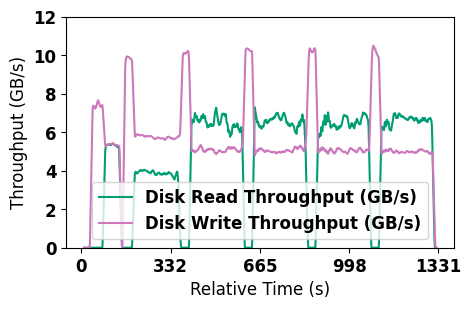

{'disk_read_bytes_throughput': 4786.541185379028, 'disk_write_bytes_throughput': 5276.7698221206665}


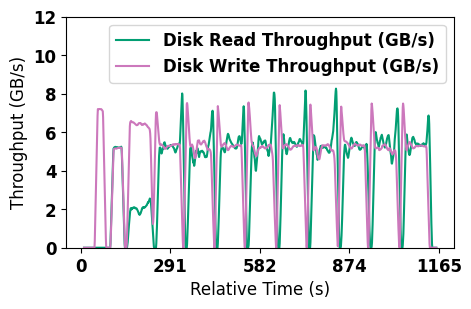

{'disk_read_bytes_throughput': 4599.013005256653, 'disk_write_bytes_throughput': 5096.496716499329}


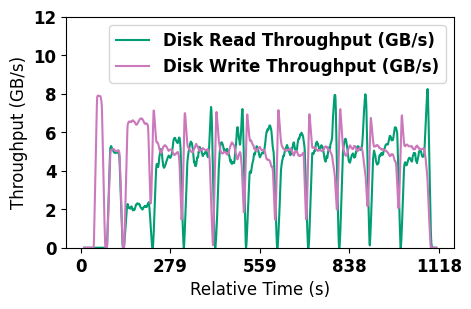

In [108]:
###############################################################
# Plot I/O throughput and cpu utilizations
###############################################################
def parse_monitoring_csv(filename):
    # Read and sort the CSV file
    df = pd.read_csv(filename).sort_values("timestamp").reset_index(drop=True)
    df['timestamp'] = pd.to_datetime(df['timestamp'], unit='ns')
    # Calculate the time difference between rows in seconds
    time_diff = df['timestamp'].diff().dt.total_seconds()
    
    # Calculate throughput directly from existing byte differences
    for column in ['disk_read_bytes', 'disk_write_bytes', 'net_read_bytes', 'net_write_bytes']:
        df[column + '_throughput'] = df[column] / time_diff / (1024 ** 3)  # Convert to GB/s
    
    # Drop the first row due to NaN values from diff operation
    df = df.dropna().reset_index(drop=True)
    
    return df

def plot_monitoring_throughput(df, smooth_interval=10):
    # Calculate smoothed values using rolling median and mean to preserve peaks
    for column in ['disk_read_bytes_throughput', 'disk_write_bytes_throughput', 
                   'net_read_bytes_throughput', 'net_write_bytes_throughput']:
        df[column + '_smoothed'] = df[column].rolling(window=smooth_interval, center=True).median()
        df[column + '_smoothed'] = df[column + '_smoothed'].rolling(window=smooth_interval, center=True).mean()
    
    df['relative_time'] = (df['timestamp'] - df['timestamp'].iloc[0]) / pd.Timedelta(seconds=1)    
    max_time = df['relative_time'].iloc[-1]
    num_labels = 5
    x_tick_positions = [max_time * i / (num_labels - 1) for i in range(num_labels)]
    x_tick_labels = [f"{int(x)}" for x in x_tick_positions]
    
    total_time = df['relative_time'].iloc[-1]-df['relative_time'].iloc[0]
    
    averages = {
        'disk_read_bytes_throughput': (df['disk_read_bytes'].sum()/(1024**3)),
        'disk_write_bytes_throughput': (df['disk_write_bytes'].sum()/(1024**3))
    }
    print(averages)
    plt.figure(figsize=(5,3))
    plt.ylim(top=12)
    sns.lineplot(x='relative_time', y='disk_read_bytes_throughput_smoothed', 
                 data=df, label='Disk Read Throughput (GB/s)', color=colors[0])
    sns.lineplot(x='relative_time', y='disk_write_bytes_throughput_smoothed', 
                 data=df, label='Disk Write Throughput (GB/s)', color=colors[1])
    
    # Add horizontal dotted lines for average throughputs and annotate with arrows
    for i, (label, avg) in enumerate(averages.items()):
        plt.axhline(y=avg, color=colors[i], linestyle='--', linewidth=1)
        plt.annotate(
            f'{avg:.2f} GB/s',
            xy=(max_time, avg),
            xytext=(max_time - 0.05 * max_time, avg + (0.05 * i)),
            arrowprops=dict(facecolor='black', shrink=0.05),
            fontsize=10,
            ha='right'
        )
    
    plt.xticks(x_tick_positions, labels=x_tick_labels)
    plt.xlabel('Relative Time (s)')
    plt.ylabel('Throughput (GB/s)')
    plt.legend()
    plt.show()
    

res = {}
for model in [40]:
    config = copy.deepcopy(base_config)
    res[model] = {}
    for k in [0, 3, 4]:
        res[model][k] = None
        config['basepath'] = f"./dl-io-outputs-test-dist-nvme-swap/act-output-{model}B"
        config['opt_gaps'] = k
        config['dp'] = 4
        config['mbs'] = 1
        config['tp'] = 1
        config['gbs'] = config['mbs']*config['dp']
        config["monitoring"] = 1
        # print("Got config as ", config)
        ans = None
        if k==0:
            config['approach'] = DEFAULT_DEEPSPEED
            config['cache'] = 0
            config['skip_grads'] = 0
            config['opt_ratio'] = 0
        elif k == 1:
            config['approach'] = ENABLE_CACHING
            config['cache'] = 1
            config['skip_grads'] = 0
            config['opt_ratio'] = 0
        elif k == 2:
            config['approach'] = SKIP_GRADS
            config['cache'] = 1
            config['skip_grads'] = 1
            config['opt_ratio'] = 0
        elif k == 3:
            config['approach'] = FULLY_OPTIMIZED
            config['cache'] = 1
            config['skip_grads'] = 1
            config['opt_ratio'] = 3
            config['fs'] = "tmp-vast"
        elif k == 4:
            config['approach'] = FULLY_OPTIMIZED
            config['cache'] = 1
            config['skip_grads'] = 1
            config['opt_ratio'] = 3
            config['single_proc'] = 1
            config['fs'] = "tmp-vast"
        else:
            print("Undefined K... Returning")
            import pdb; pdb.set_trace()
        filename = get_filename(MODELS[model], config)
        df.sort_values('timestamp')
#         print(df)
        df = parse_monitoring_csv(filename)
        plot_monitoring_throughput(df)


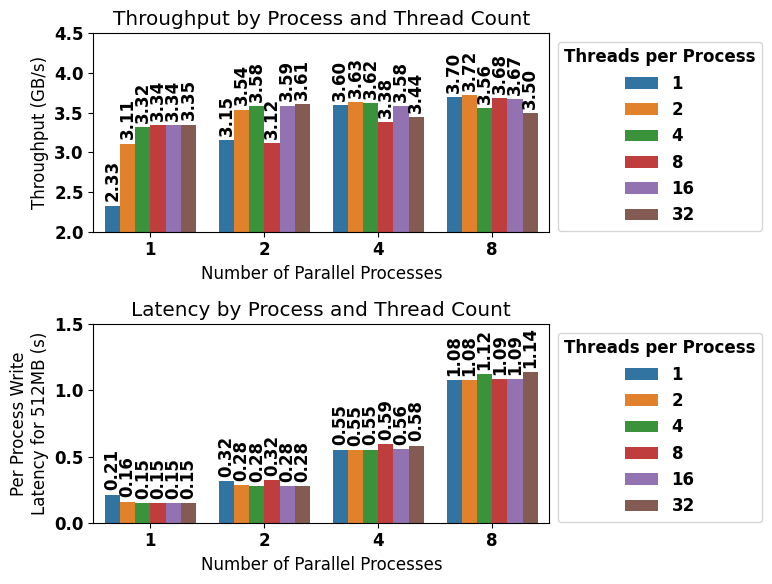

In [131]:
###############################################################
# Plot raw AIO statistics to find optimal processes, threads
###############################################################
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Load data
data = {
    "PROCESSES": [1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 4, 4, 4, 4, 4, 4, 8, 8, 8, 8, 8, 8],
    "THREADS_PER_PROC": [1, 2, 4, 8, 16, 32, 1, 2, 4, 8, 16, 32, 1, 2, 4, 8, 16, 32, 1, 2, 4, 8, 16, 32],
    "THROUGHPUT": [2.33, 3.11, 3.32, 3.34, 3.34, 3.35, 3.15, 3.54, 3.58, 3.12, 3.59, 3.61, 3.60, 3.63, 3.62, 3.38, 3.58, 3.44, 3.70, 3.72, 3.56, 3.68, 3.67, 3.50],
    "LATENCY": [0.64, 0.48, 0.45, 0.45, 0.45, 0.45, 0.95, 0.85, 0.84, 0.96, 0.83, 0.83, 1.66, 1.65, 1.66, 1.78, 1.67, 1.75, 3.24, 3.23, 3.37, 3.26, 3.26, 3.42]
}
num_loop = 3
data["LATENCY"] = [x/num_loop for x in data["LATENCY"]]

# Convert to DataFrame
df = pd.DataFrame(data)

# Set up the figure and subplots
fig, axes = plt.subplots(2, 1, figsize=(8, 6), sharex=False)

# Define colors
color = "steelblue"

# Throughput Plot
sns.barplot(
    x="PROCESSES", y="THROUGHPUT", hue="THREADS_PER_PROC", data=df, ax=axes[0]
)
axes[0].set_title("Throughput by Process and Thread Count")
axes[0].set_ylabel("Throughput (GB/s)")
axes[0].set_ylim(bottom=2, top=4.5)
axes[0].legend(title="Threads per Process", loc="upper left", bbox_to_anchor=(1, 1))
axes[0].set_xlabel("Number of Parallel Processes")

# Annotate values on top of the bars
for container in axes[0].containers:
    axes[0].bar_label(container, fmt="%.2f", padding=3, rotation=90)

# Latency Plot
sns.barplot(
    x="PROCESSES", y="LATENCY", hue="THREADS_PER_PROC", data=df, ax=axes[1]
)
axes[1].set_title("Latency by Process and Thread Count")
axes[1].set_ylabel("Per Process Write\nLatency for 512MB (s)")
axes[1].legend(title="Threads per Process", loc="upper left", bbox_to_anchor=(1, 1))

# Annotate values on top of the bars
for container in axes[1].containers:
    axes[1].bar_label(container, fmt="%.2f", padding=3, rotation=90)
axes[1].set_ylim(bottom=0, top=1.5)
# Adjust layout and save
plt.xlabel("Number of Parallel Processes")
plt.tight_layout()
plt.savefig("throughput_latency_grouped_bars.png", dpi=300, bbox_inches="tight")
plt.show()


In [399]:
###############################################################
# Plot for the read/write throughput observed by each subgroup
###############################################################

def parse_log_and_calculate_throughputs(logfile_path):
    with open(logfile_path, 'r') as f:
        log_data = f.readlines()
    
    sizes = {}
    read_times = defaultdict(list)
    write_times = defaultdict(list)
    
    # Flags for parsing
    found_sizes = False
    tflop_occurrences = 0
    parse_interval = False

    # Regular expressions
    sizes_pattern = re.compile(r"-> sizes: (.+)")
    read_wait_pattern = re.compile(r"-> read_wait\[(\d+)\]\[(\d+)\]: ([\d.]+)")
    write_wait_pattern = re.compile(r"-> write_wait\[(\d+)\]\[(\d+)\]: ([\d.]+)")
    tflop_pattern = re.compile(r"TFLOPs")

    for line in log_data:
        # Capture sizes once
        if not found_sizes:
            match = sizes_pattern.search(line)
            if match:
                sizes.update(json.loads(match.group(1)))
                sizes = list(sizes.values())[0]
                found_sizes = True
                continue
        
        # Check for TFLOP occurrences
        if tflop_pattern.search(line):
            tflop_occurrences += 1
            if tflop_occurrences == 3:
                parse_interval = True
            elif tflop_occurrences == 4:
                break
            continue
        
        # Parse read/write times within the specified interval
        if parse_interval:
            read_match = read_wait_pattern.search(line)
            if read_match:
                rank, subgroup, time = int(read_match.group(1)), int(read_match.group(2)), float(read_match.group(3))
                read_times[subgroup].append(time)
            
            write_match = write_wait_pattern.search(line)
            if write_match:
                rank, subgroup, time = int(write_match.group(1)), int(write_match.group(2)), float(write_match.group(3))
                write_times[subgroup].append(time)

    # Calculate throughputs
    results = {'read_throughputs': [], 'write_throughputs': []}
    for subgroup in sorted(read_times.keys()):
        numel = sizes[subgroup]  # Size is the same across ranks
        to_GB = (1024**3)
        assert len(read_times[subgroup]) == 4, f"Problem with {subgroup}"
        avg_read_time = sum(read_times[subgroup]) / len(read_times[subgroup])
        avg_write_time = sum(write_times[subgroup]) / len(write_times[subgroup])
        
        # Note that we will read 4 tensors: p, m, v, g
        # We will only write back p, m, v
#         print("Avg read: ", subgroup, (numel * 4 * 4 / to_GB), read_times[subgroup], avg_read_time )
        read_throughput = (numel * 4 * 4 / to_GB) / avg_read_time  # Convert bytes to GB
        write_throughput = (numel * 4 * 3 / to_GB) / avg_write_time 
        
        results['read_throughputs'].append(read_throughput)
        results['write_throughputs'].append(write_throughput)
    print("Read avg: ", get_avg(results['read_throughputs']))
    print("Write avg: ", get_avg(results['write_throughputs']))
    return results

res = {}
for model in [40]:
    config = copy.deepcopy(base_config)
    res[model] = {}
    for k in [0]:
        res[model] = None
        config['basepath'] = f"./dl-io-outputs-test-dist-nvme-swap/act-output-{model}B"
        config['opt_gaps'] = k
        config['dp'] = 4
        config['mbs'] = 1
        config['tp'] = 1
        config['gbs'] = config['mbs']*config['dp']
        ans = None
        config['approach'] = approach_code[k]
        if k==0:
            config['cache'] = 0
            config['skip_grads'] = 0
            config['opt_ratio'] = 0
            config['pipelinerw'] = 1
        else:
            print("Undefined K... Returning")
            import pdb; pdb.set_trace()
        filename = get_filename(MODELS[model], config)
        res[model] = parse_log_and_calculate_throughputs(filename)
        print("reading ", filename)
        
print(res)

Read avg:  1930.2923669820104
Write avg:  16.127654469529556
reading  ./dl-io-outputs-test-dist-nvme-swap/act-output-40B/log-40B-tp1-dp4-l128-h5120-a40-sl2048-gbs4-mbs1-ratio1-subg100000000-pipelinerw1-opt_ratio0-cache0-skip_grads0-single_proc0-compress0-tmp.log
{40: {'read_throughputs': [0.21176483193212498, 1.8513033087084922, 3419.013550135501, 5371.179878479582, 1.3650196324293602, 1.5312715400602184, 5272.099861303745, 1.4332397979512703, 1.5514721028169265, 3419.868645973909, 2.1933026550422206, 2.6802635488249087, 5325.2787895769125, 1.780806325296564, 3.8035447043486963, 5268.446292446292, 2.293653791616122, 2.586096647576954, 5327.517869656623, 2.652130174194038, 2.4279079631330625, 5240.121312379377, 2.6419307562015053, 3.4130790473799486, 5240.121312379377, 2.347409990492128, 4.5503469523413465, 5271.368742199417, 2.4758708717073894, 3.385260484789664, 5304.471113591962, 2.502073557615702, 4.637647063580651, 5374.977375565611, 2.3573958120212994, 2.7031495814145825, 5432.591